<a href="https://colab.research.google.com/github/VerbVal/testrepository/blob/main/DS_16_FMCG_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Прогнозирование продаж товаров категории FMCG на основе ежедневных данных с помощью методов машинного обучения**

## Основные положения
### Цель исследования:

Разработать надежную модель, предсказывающую продажи товаров, учитывающую сезонные колебания, наличие товаров на складе, цены и промоакции. Модель должна демонстрировать хорошую обобщающую способность как во времени, так и по категориям.

### Подход:


*   Загрузка и и предварительная обработка данных, включая правильное преобразование формата дат
*   Проведение серии визуализаций для анализа распределения целевой переменной и выявления взаимосвязей между ключевыми переменными
*   Выбор переменных и создание новых для дальнейшего анализа
*   Моделирование
*   Сравнение моделей
*   Предложения по дальнейшему развитию исследования

# Обзор набора данных
Источник данных:
[Kaggle - FMCG Daily Sales Data 2022-2024](https://www.kaggle.com/datasets/beatafaron/fmcg-daily-sales-data-to-2022-2024/data?select=FMCG_2022_2024.csv)
Датасет представляет собой набор синтетических данных о ежедневных продажах товаров повседневного спроса (FMCG) за период с 2022 по 2024 год. Степень детализации датасета: содержит информацию о товарах, включая их категории, названия и уникальные идентификаторы, даты совершения продаж, объемы продаж за день, финансовые показатели, отражающие общую выручку от продаж, а также данные о местах, где происходили продажи.


### Импорт нужных для исследования библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.optim import adam

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, f_classif, SelectKBest
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
from sklearn.base import clone
from scipy import stats
from lightgbm import LGBMRegressor
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [ ]:
# игнорирование разных предупреждений системы
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Загрузка и обработка данных

In [ ]:
file_id = "1JTIIb3AgDsjwisTxvuMjL3ww6dm3qqc0"
url = f"https://drive.google.com/uc?id={file_id}"
df = pd.read_csv(url)

### Структура и характеристики набора данных

In [ ]:
print(df.columns)
df

Index(['date', 'sku', 'brand', 'segment', 'category', 'channel', 'region',
       'pack_type', 'price_unit', 'promotion_flag', 'delivery_days',
       'stock_available', 'delivered_qty', 'units_sold'],
      dtype='object')


,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190752,2024-12-31,SN-030,SnBrand2,SnackBar-Seg1,SnackBar,Discount,PL-North,Single,2.55,0,2,190,163,25
190753,2024-12-31,SN-030,SnBrand2,SnackBar-Seg1,SnackBar,Discount,PL-South,Single,6.01,0,5,141,131,19
190754,2024-12-31,SN-030,SnBrand2,SnackBar-Seg1,SnackBar,E-commerce,PL-Central,Single,3.45,0,5,0,132,0
190755,2024-12-31,SN-030,SnBrand2,SnackBar-Seg1,SnackBar,E-commerce,PL-North,Multipack,1.93,1,2,211,201,40


|Переменная                   | Описание |
|--------------------------------|------|
| 1. **`date`**                 | дата продажи |
| 2. **`sku`**              | идентификатор товара |
| 3. **`brand`** | бренд товара |
| 4. **`segment`**           | сегмент товара |
| 5. **`category`**          | категория товара |
| 6. **`channel`**    | канал сбыта |
| 7. **`region`** | место продажи, регион |
| 8. **`pack_type`**| тип упаковки |
| 9. **`price_unit`**| цена ед. товара |
| 10. **`promotion_flag`**|  флаг промоакции |
| 11. **`delivery_days`** | доставка, дн.  |
| 12. **`stock_available`** | доступный запас, ед.  |
| 13. **`delivered_qty`** | доставлено, ед.  |
| 14. **`units_sold`**    | продано, ед.   |

In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190757 entries, 0 to 190756
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             190757 non-null  object 
 1   sku              190757 non-null  object 
 2   brand            190757 non-null  object 
 3   segment          190757 non-null  object 
 4   category         190757 non-null  object 
 5   channel          190757 non-null  object 
 6   region           190757 non-null  object 
 7   pack_type        190757 non-null  object 
 8   price_unit       190757 non-null  float64
 9   promotion_flag   190757 non-null  int64  
 10  delivery_days    190757 non-null  int64  
 11  stock_available  190757 non-null  int64  
 12  delivered_qty    190757 non-null  int64  
 13  units_sold       190757 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 20.4+ MB


(190757, 14)

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')# перевод data из строкового типа в datetime

print(df.dtypes[['date']].to_string())# проверка перевода

date    datetime64[ns]


In [ ]:
print("Min date:", df['date'].min())
print("Max date:", df['date'].max())

Min date: 2022-01-21 00:00:00
Max date: 2024-12-31 00:00:00


In [ ]:
# Проверка на наличие нулевых значений
print('Missing values in each column:')
df.isnull().sum()

Missing values in each column:


,0
date,0
sku,0
brand,0
segment,0
category,0
channel,0
region,0
pack_type,0
price_unit,0
promotion_flag,0


In [ ]:
# Проверка на наличие пропусков NaN
df.isna().sum()

,0
date,0
sku,0
brand,0
segment,0
category,0
channel,0
region,0
pack_type,0
price_unit,0
promotion_flag,0


In [ ]:
all_dates = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
all_skus = df['sku'].unique()

full_grid = pd.DataFrame([(date, sku) for date in all_dates for sku in all_skus], columns=['date', 'sku'])

existing = df[['date', 'sku']].drop_duplicates()

merged = full_grid.merge(existing, on=['date', 'sku'], how='left', indicator=True)
missing = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

print(f"Missing (date, SKU) combinations: {len(missing)}")
display(missing.head(5))

Missing (date, SKU) combinations: 7335


,date,sku
1,2022-01-21,MI-026
2,2022-01-21,YO-029
3,2022-01-21,YO-005
4,2022-01-21,YO-012
5,2022-01-21,YO-014


Ни на каждую дату есть значения для отдельных SKU. Это связанно с жизненным циклом товара, т.е. в какой-то период товар еще не закупался или уже не закупался.

In [ ]:
# Вывод описательных статистик числовых столбцов таблицы
print('\nSummary Statistics:')
df.describe()


Summary Statistics:


,date,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
count,190757,190757.000000,190757.000000,190757.000000,190757.000000,190757.000000,190757.000000
mean,2023-10-28 04:11:33.514785536,5.251979,0.149200,3.004860,157.697652,179.333655,19.919709
min,2022-01-21 00:00:00,1.500000,0.000000,1.000000,-12.000000,-11.000000,-25.000000
25%,2023-04-16 00:00:00,3.380000,0.000000,2.000000,124.000000,152.000000,12.000000
50%,2023-11-12 00:00:00,5.250000,0.000000,3.000000,155.000000,179.000000,18.000000
75%,2024-06-07 00:00:00,7.130000,0.000000,4.000000,192.000000,206.000000,25.000000
max,2024-12-31 00:00:00,9.000000,1.000000,5.000000,405.000000,366.000000,139.000000
std,NaN,2.166705,0.356287,1.414626,52.736104,40.037475,11.770077


Вижу аномальные значения для stock_available, delivered_qty, units_sold. С ними разберусь отдельно.

In [ ]:
df.describe(include=['object'])# описательные характеристики категориальных переменных

,sku,brand,segment,category,channel,region,pack_type
count,190757,190757,190757,190757,190757,190757,190757
unique,30,14,13,5,3,3,3
top,MI-006,SnBrand2,Yogurt-Seg1,Yogurt,Retail,PL-North,Carton
freq,8221,26775,26851,72707,63688,63645,63671


In [ ]:
# вывод уникальных значений категориальных переменных
cat_cols = ['sku', 'brand', 'segment', 'category', 'channel', 'region', 'pack_type']

for col in cat_cols:
    unique_values = np.unique(df[col], return_counts=True)
    print(f"unique values in {col}:")
    display(unique_values)


unique values in sku:


(array(['JU-021', 'MI-002', 'MI-006', 'MI-008', 'MI-011', 'MI-022',
        'MI-023', 'MI-026', 'RE-004', 'RE-007', 'RE-015', 'RE-017',
        'RE-025', 'SN-010', 'SN-013', 'SN-019', 'SN-027', 'SN-028',
        'SN-030', 'YO-001', 'YO-003', 'YO-005', 'YO-009', 'YO-012',
        'YO-014', 'YO-016', 'YO-018', 'YO-020', 'YO-024', 'YO-029'],
       dtype=object),
 array([6943, 5067, 8221, 4777, 4863, 6249, 7202, 8216, 7643, 7489, 7366,
        5748, 5990, 5870, 5501, 5229, 6435, 4749, 4492, 7574, 6341, 7893,
        6778, 7719, 7630, 5991, 4606, 5416, 4850, 7909]))

unique values in brand:


(array(['JuBrand3', 'MiBrand1', 'MiBrand2', 'MiBrand3', 'MiBrand4',
        'ReBrand1', 'ReBrand2', 'ReBrand4', 'SnBrand2', 'SnBrand3',
        'YoBrand1', 'YoBrand2', 'YoBrand3', 'YoBrand4'], dtype=object),
 array([ 6943, 13084,  5067, 18228,  8216,  7643, 11738, 14855, 26775,
         5501, 14060, 17349, 18981, 22317]))

unique values in segment:


(array(['Juice-Seg3', 'Milk-Seg1', 'Milk-Seg2', 'Milk-Seg3',
        'ReadyMeal-Seg1', 'ReadyMeal-Seg2', 'ReadyMeal-Seg3',
        'SnackBar-Seg1', 'SnackBar-Seg2', 'SnackBar-Seg3', 'Yogurt-Seg1',
        'Yogurt-Seg2', 'Yogurt-Seg3'], dtype=object),
 array([ 6943,  5067, 24105, 15423, 14855, 13391,  5990, 14470, 11371,
         6435, 26851, 21044, 24812]))

unique values in category:


(array(['Juice', 'Milk', 'ReadyMeal', 'SnackBar', 'Yogurt'], dtype=object),
 array([ 6943, 44595, 34236, 32276, 72707]))

unique values in channel:


(array(['Discount', 'E-commerce', 'Retail'], dtype=object),
 array([63450, 63619, 63688]))

unique values in region:


(array(['PL-Central', 'PL-North', 'PL-South'], dtype=object),
 array([63545, 63645, 63567]))

unique values in pack_type:


(array(['Carton', 'Multipack', 'Single'], dtype=object),
 array([63671, 63550, 63536]))

In [ ]:
# Проверю есть ли повторяющиеся значения в каждом отдельном столбце
isDuplicates = {}

for col in df.columns:
    ans = df[col].duplicated().sum()
    isDuplicates[col] = ans

print(isDuplicates)

{'date': np.int64(189681), 'sku': np.int64(190727), 'brand': np.int64(190743), 'segment': np.int64(190744), 'category': np.int64(190752), 'channel': np.int64(190754), 'region': np.int64(190754), 'pack_type': np.int64(190754), 'price_unit': np.int64(190006), 'promotion_flag': np.int64(190755), 'delivery_days': np.int64(190752), 'stock_available': np.int64(190402), 'delivered_qty': np.int64(190436), 'units_sold': np.int64(190622)}


Повторения есть, но это нормально.

In [ ]:
print(df.duplicated().sum())# Проверю, есть ли полные дубли строк

0


Дубликатов не найдено.

### Выявление анамалий и выбросов

Ищу нелогичные значения в числовых данных

In [ ]:
df[df['units_sold']<0]

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
70489,2023-07-26,SN-028,SnBrand2,SnackBar-Seg1,SnackBar,Discount,PL-South,Single,2.91,0,5,-2,-3,-3
83501,2023-09-21,SN-010,SnBrand2,SnackBar-Seg2,SnackBar,Retail,PL-Central,Carton,8.60,1,4,-12,-11,-25
123633,2024-03-14,RE-007,ReBrand4,ReadyMeal-Seg1,ReadyMeal,Discount,PL-Central,Carton,2.38,0,4,-6,-7,-8


Удаляю эти строки

In [ ]:
df = df[df['units_sold'] >= 0]

In [ ]:
(df[df['delivered_qty']<0])

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold


In [ ]:
df[df['stock_available']<0]

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold


## Выводы раздела
Датасет:

|                  |  |
|--------------------------------|------|
| *   **Размер датасета**:                  | **190757** строк × **14** колонок |
| *   **Временной интервал**:             | с **21.01.2022** по **31.12.2024**  |
|*   **Целевой показатель**:  | **`units_sold`** (int) - ежедневные продажи единиц товара     |
| *   **Нет пропущенных значений**         | сегмент товара |
| *   **Нет повторяющихся строк**          | категория товара |
| *   **Есть отрицательные значения**    |  **`stock_available`**, **`delivered_qty`**, **`units_sold`** |



Переменные:

|                   |  |
|--------------------------------|------|
| *   **`sku`**: **30** уникальных значений артикулов товара                |  — наиболее частотное значение **MI-006** (встречается **8221** раз) |
|*   **`brand`**: **14** уникальных значений брендов   | — наиболее частотное значение **SnBrand2** (встречается **26775**	раз) |
| *   **`segment**`: **13** уникальных значений сегментов |  — наиболее частотное значение **Yogurt-Seg1** (встречается **26851** раз) |
| *   **`category`**: **5** уникальных значений категорий|  — наиболее частотное значение **Yogurt** (встречается **72707** раз) |
| *   **`channel`**: **3** канала сбыта          | — наиболее частотное значение **Retail** (встречается **63688** раз) |
| *   **`region`**: **3** региона сбыта   | — наиболее частотное значение **PL-North** (встречается **63645** раз) |
| *   **`pack_type`**: **3** вида упаковки  | — наиболее частотное значение **Carton** (встречается **63671** раз) |


# Идентификация связей и корреляций между переменными

В данном разделе представлены визуализаций, предназначенные для выявления взаимосвязей между переменными  и трендов в данных.

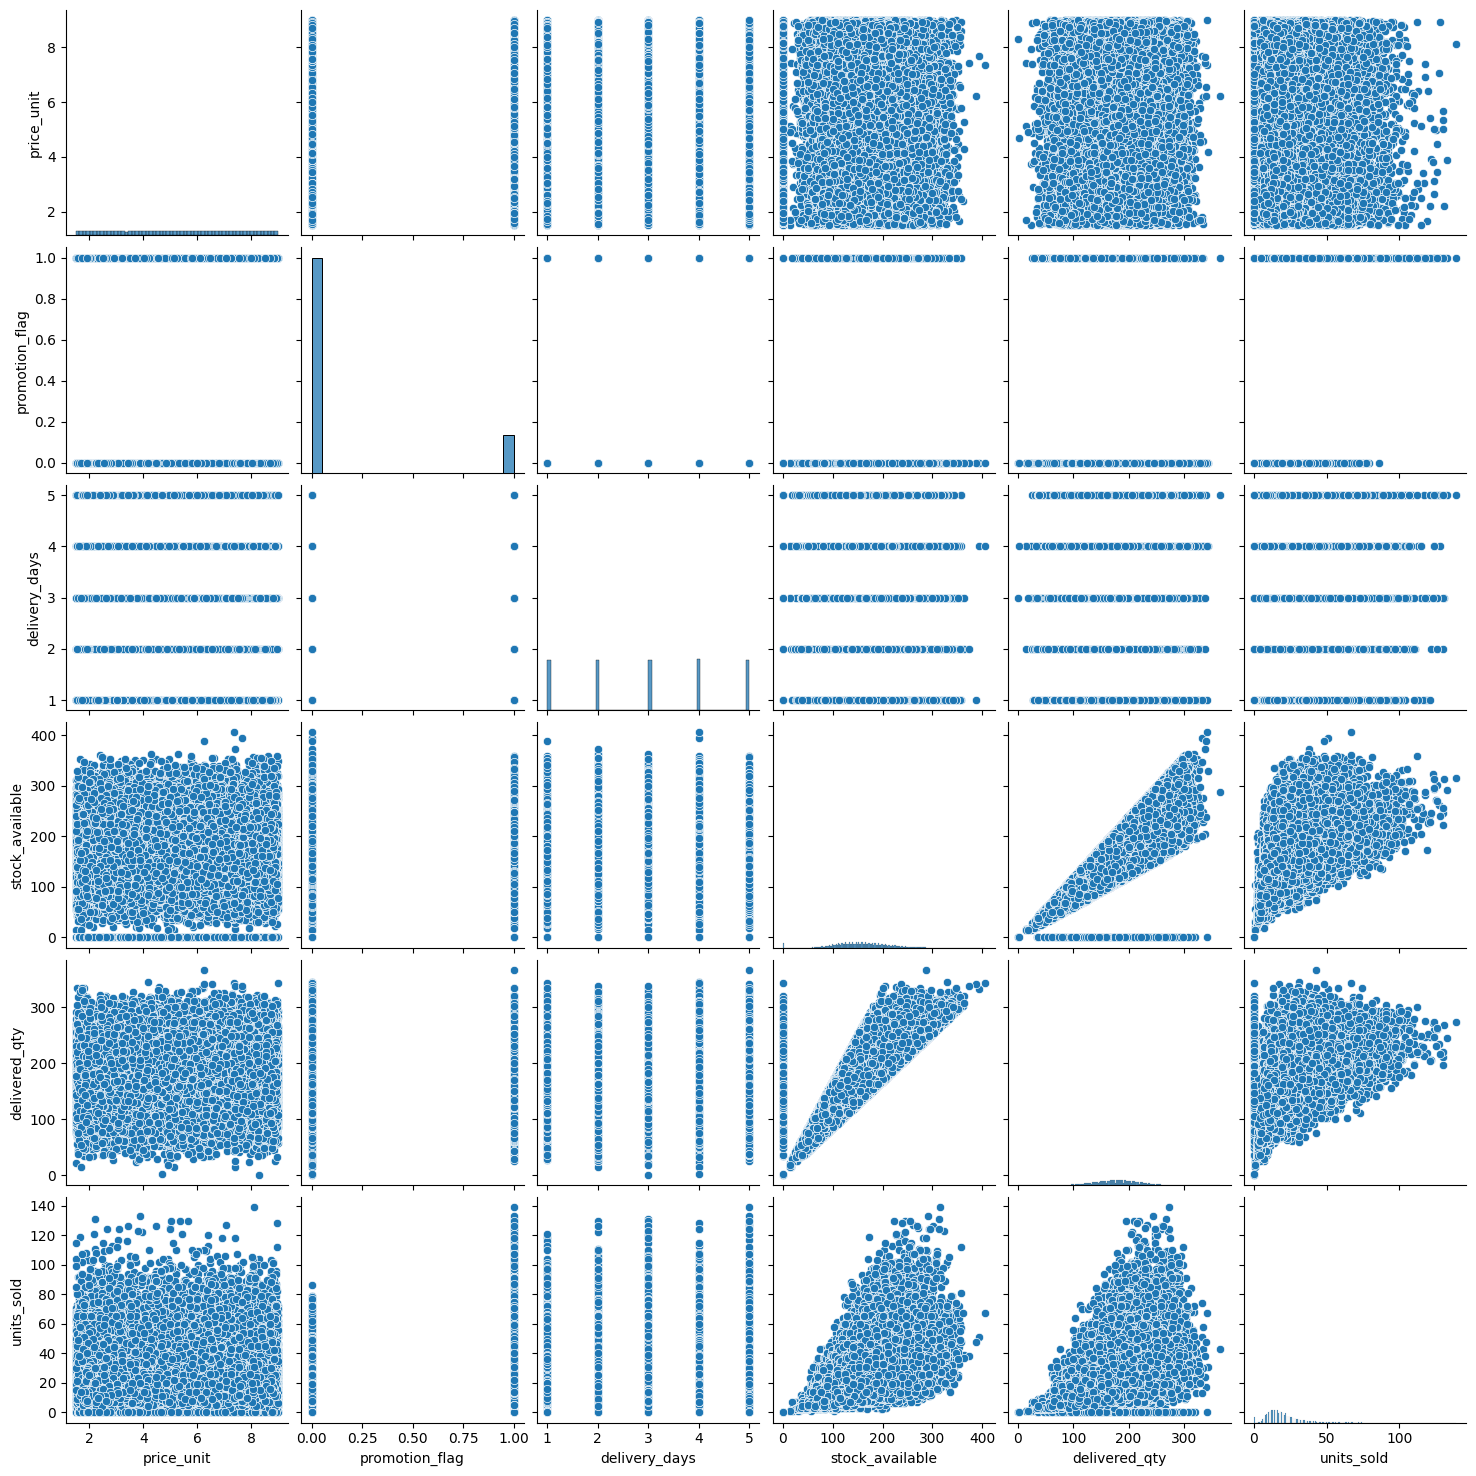

In [ ]:
fig1 = sns.pairplot(df)
plt.show()

In [ ]:
# Сохранение графика в файл
fig1.savefig('pairplot1.png', dpi=300, bbox_inches='tight')  # Сохраните в формате PNG, с высоким разрешением


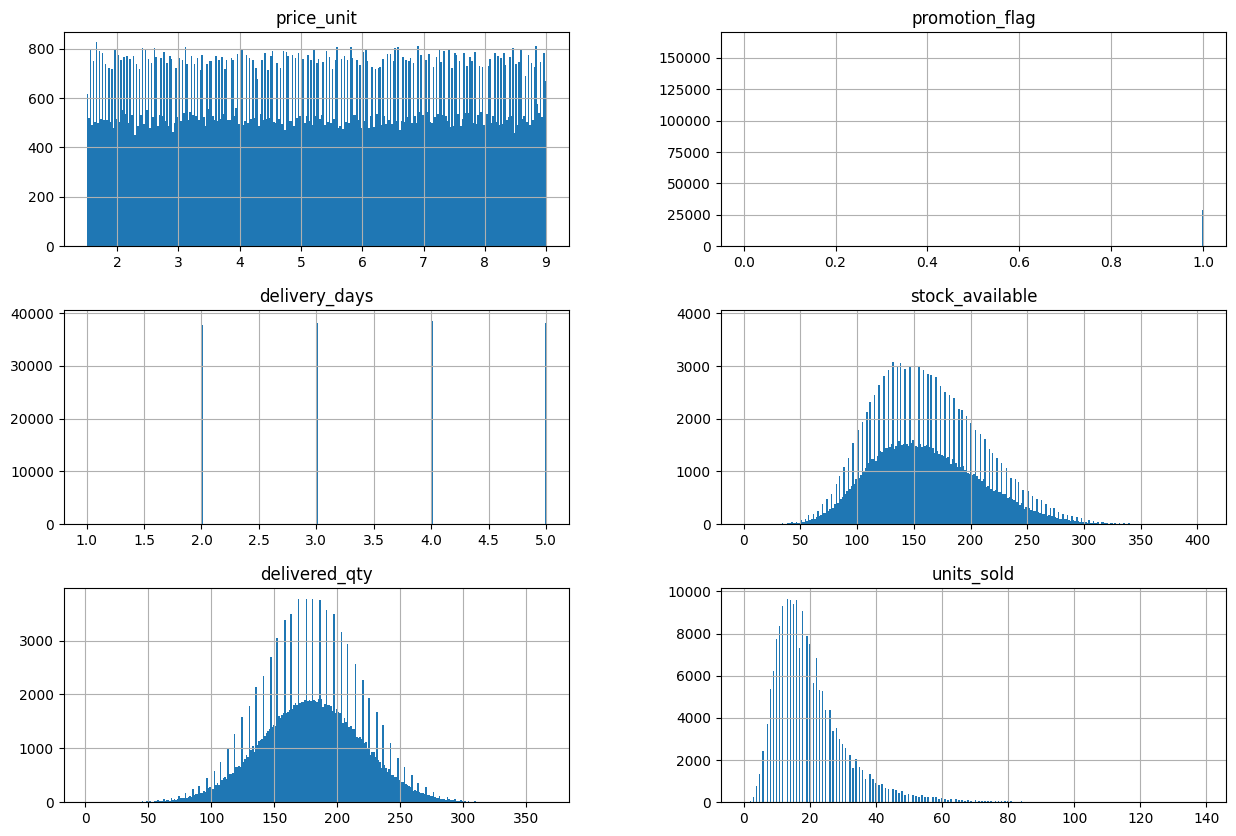

In [ ]:
df.select_dtypes(include=['float64', 'int64']).hist(bins=300, figsize=(15, 10))# Посмотрю отдельно распределение числовых значений
plt.show()

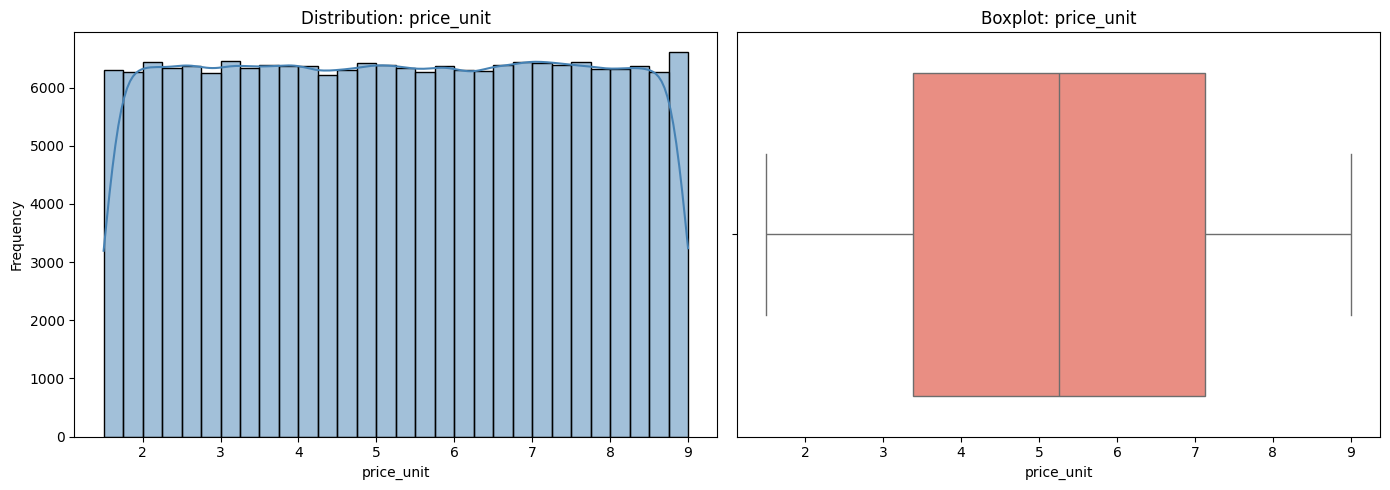

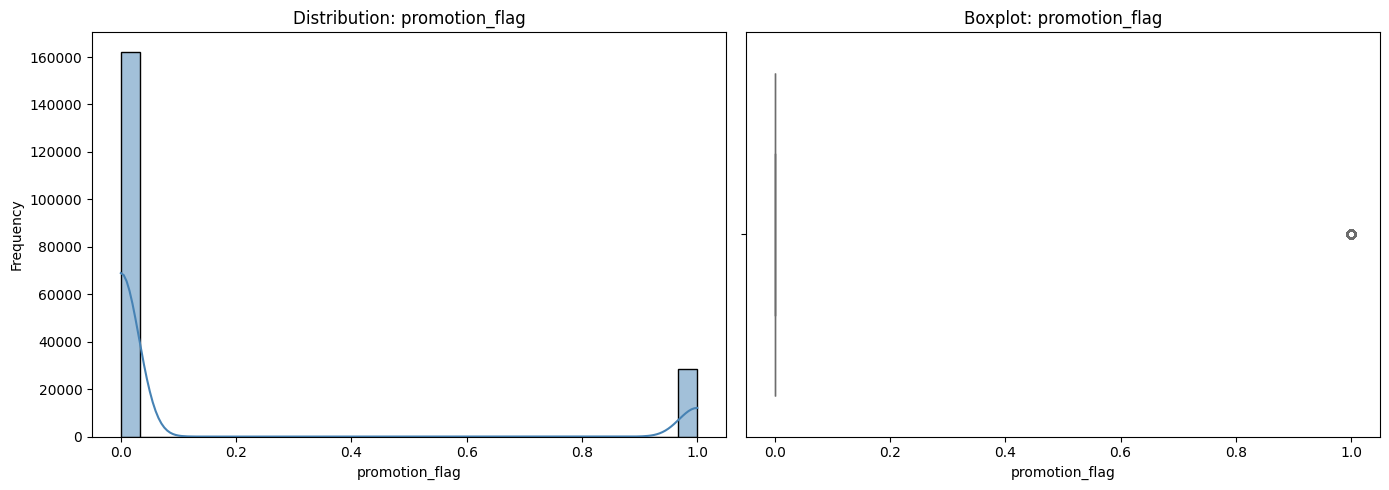

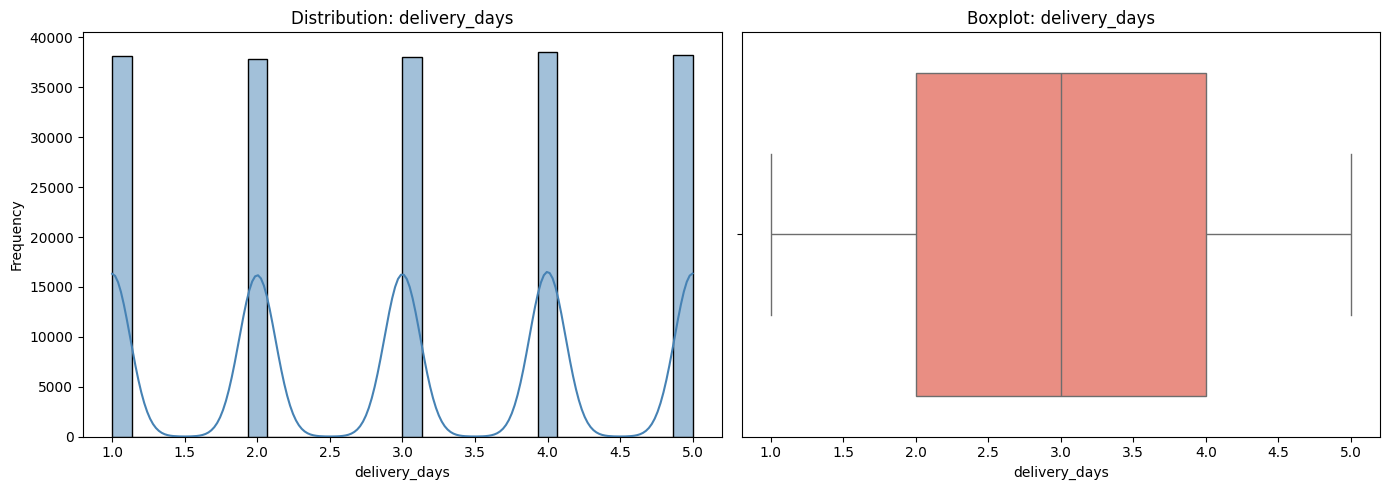

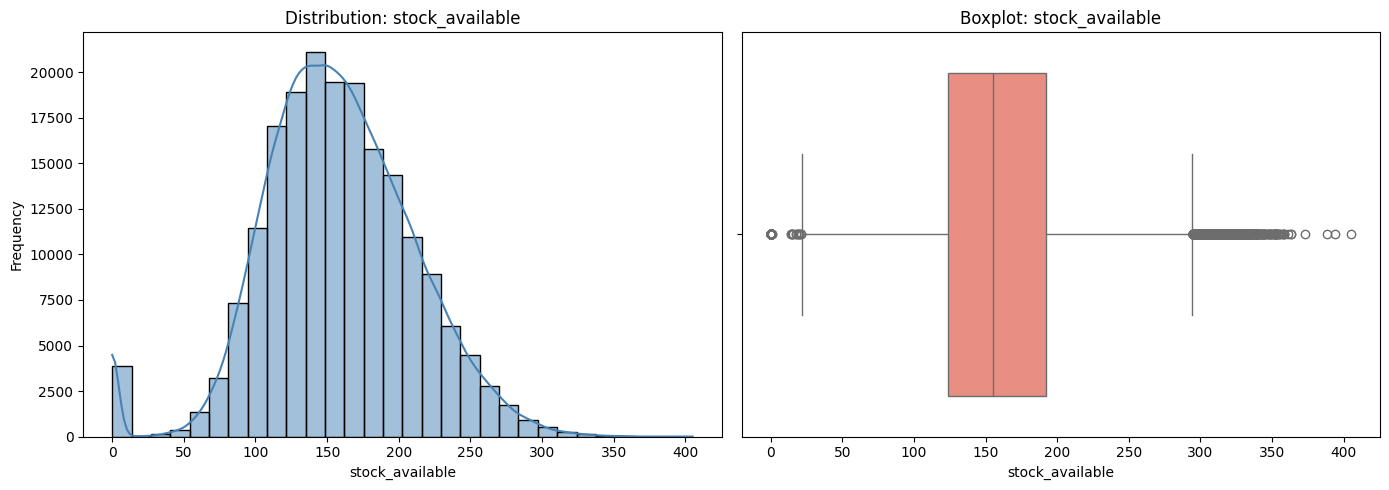

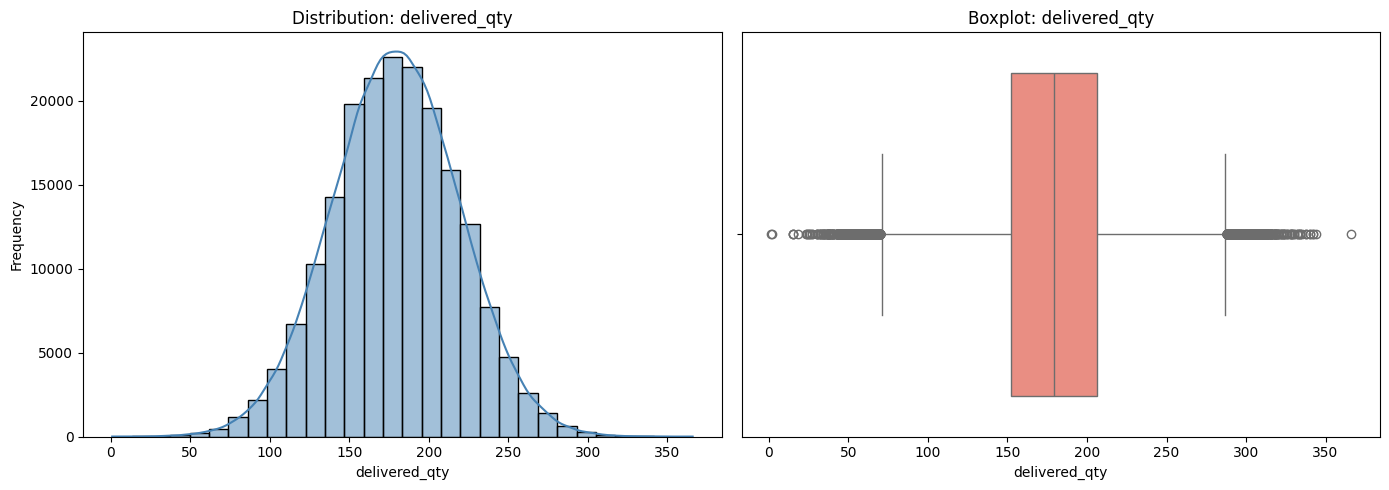

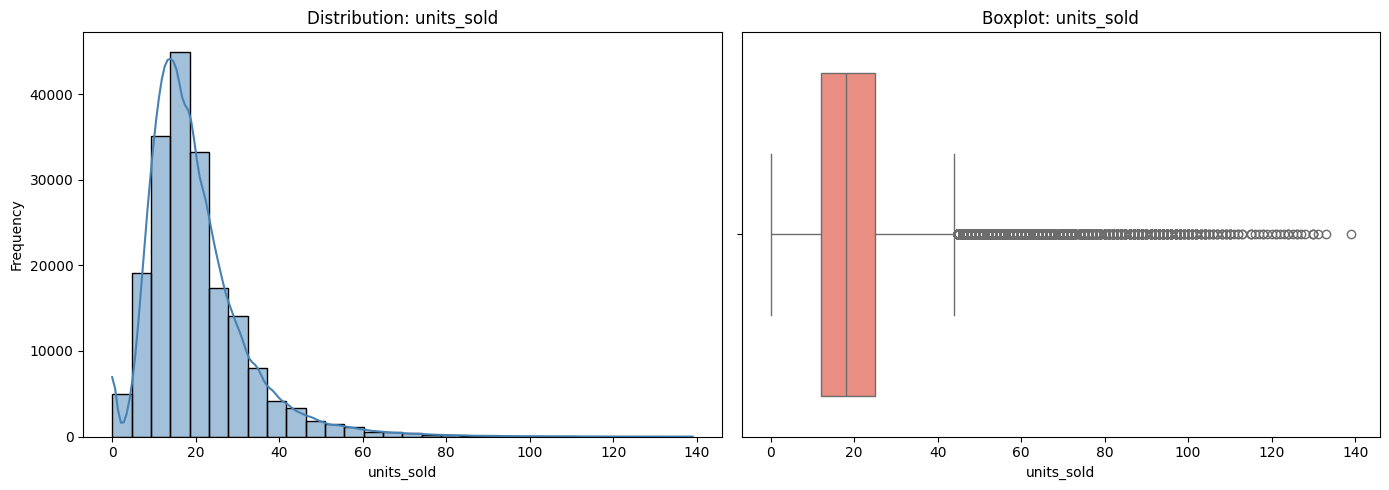

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color='steelblue')
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f"Boxplot: {col}")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

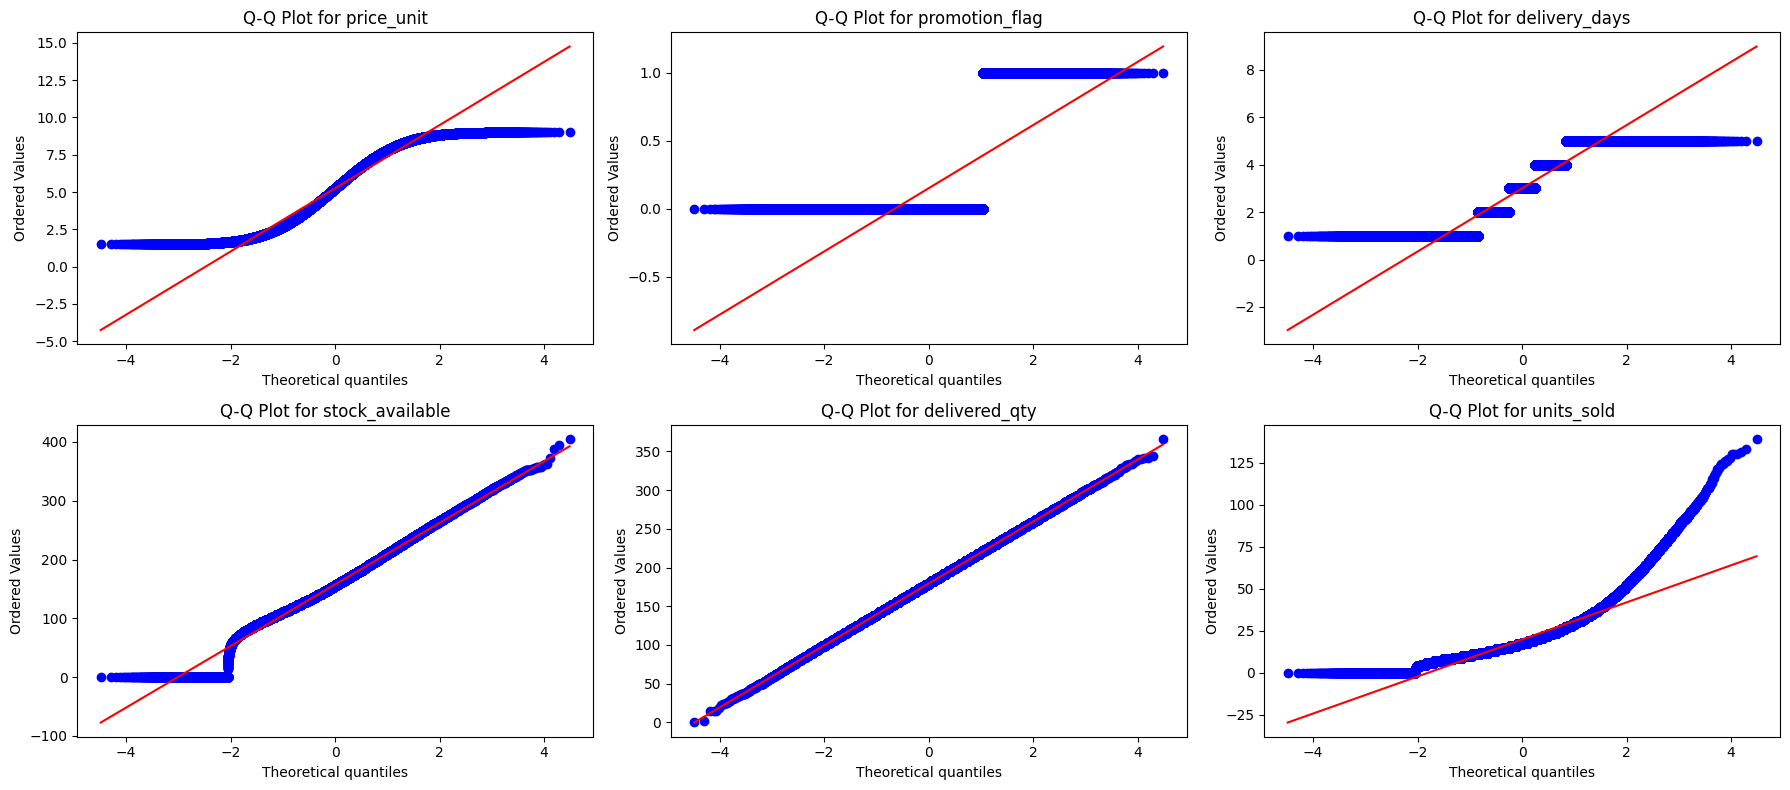

In [ ]:
# квантиль-квантиль график для сравнения распределения с нормальным
num_cols = len(numeric_cols)

n_rows = 2
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if i < n_rows * n_cols:
        stats.probplot(df[col], dist="norm", plot=axes[i])
        axes[i].set_title(f'Q-Q Plot for {col}')

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

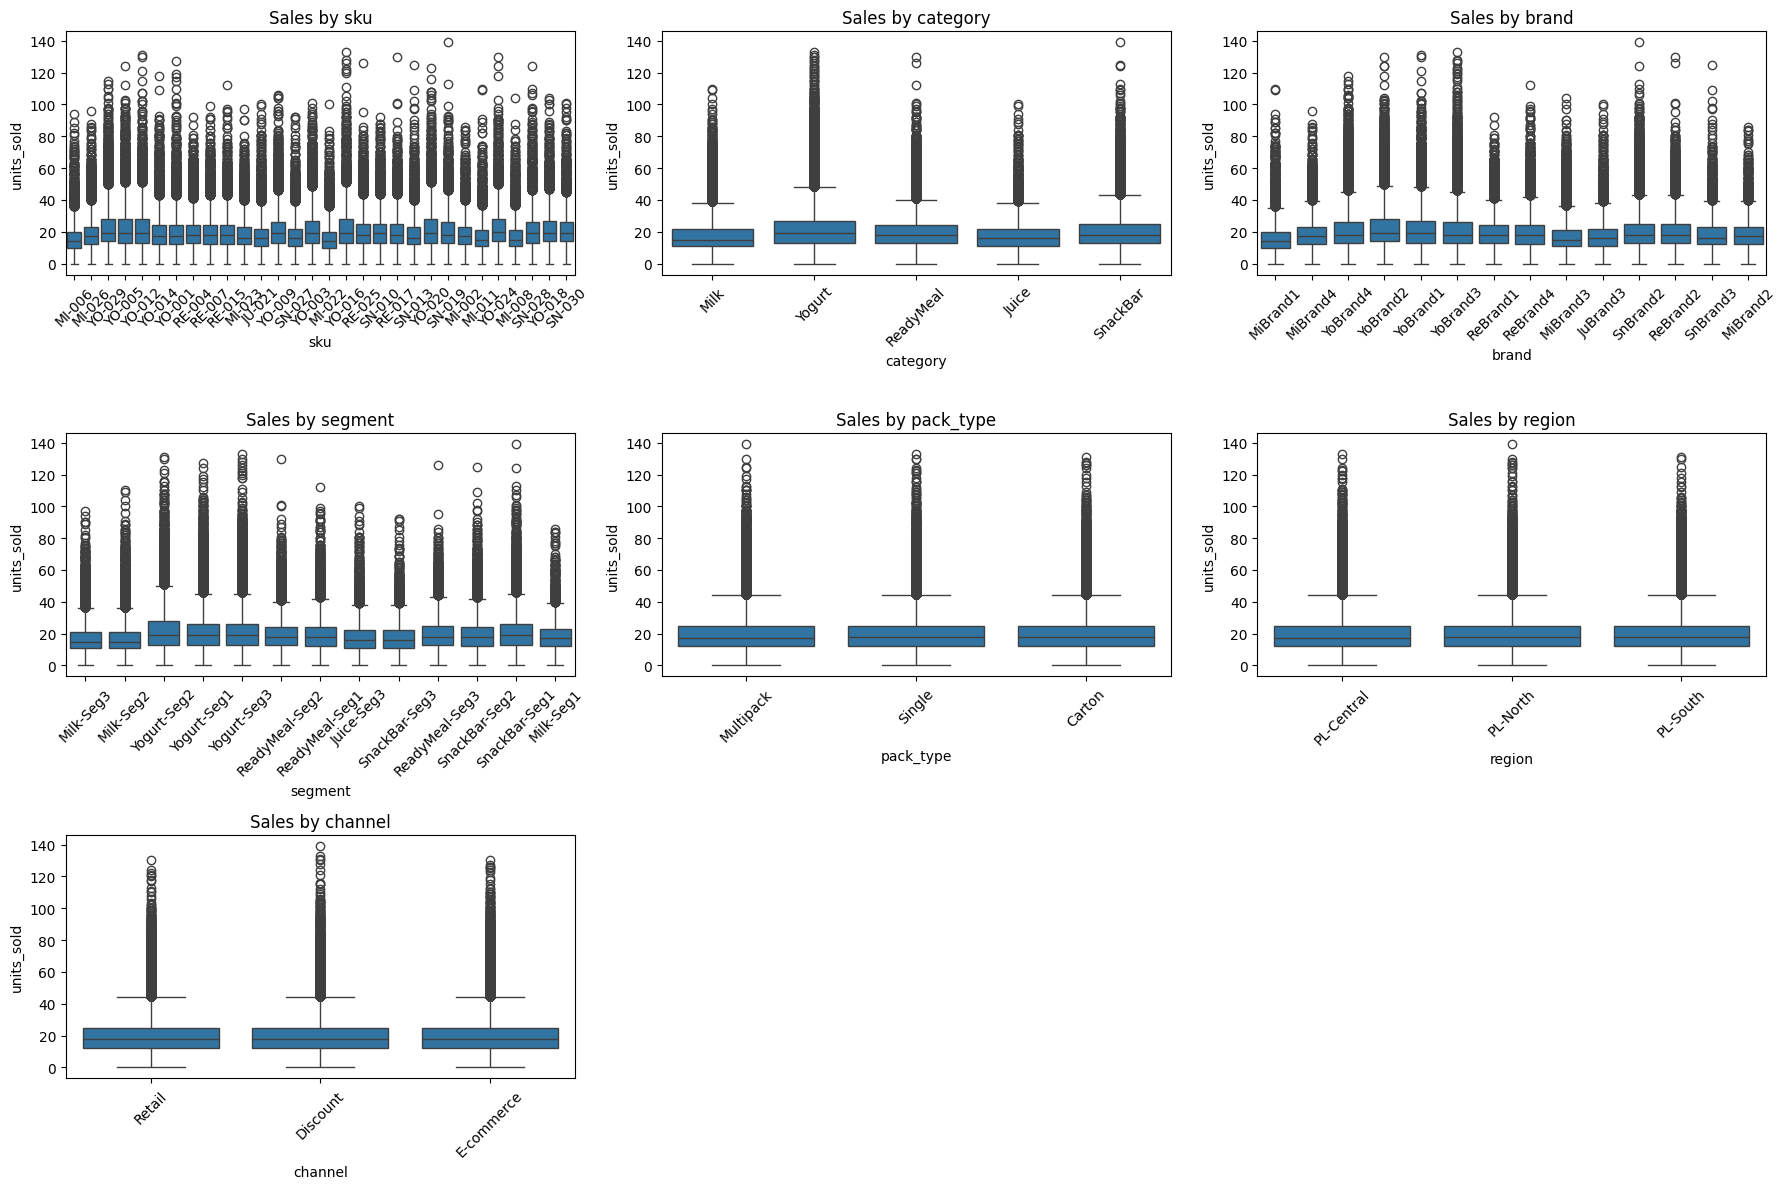

In [ ]:
box_columns = ['sku','category','brand','segment','pack_type','region','channel']
num_plots = len(box_columns)

rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

for i, col_name in enumerate(box_columns):
    sns.boxplot(x=col_name, y='units_sold', data=df, ax=axes[i])
    axes[i].set_title(f"Sales by {col_name}")
    axes[i].tick_params(axis='x', labelrotation=45)

for j in range(len(box_columns), rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Axes: xlabel='category', ylabel='price_unit'>

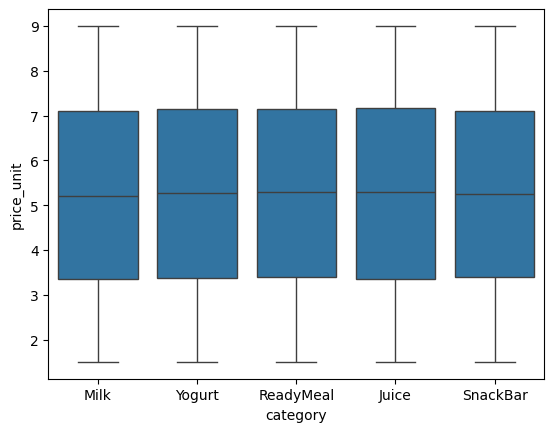

In [ ]:
sns.boxplot(x='category', y='price_unit', data=df)# распределение цены по категориям

In [ ]:
print(df.groupby('promotion_flag')['units_sold'].mean())

promotion_flag
0    17.440183
1    34.062649
Name: units_sold, dtype: float64


<Axes: xlabel='promotion_flag', ylabel='units_sold'>

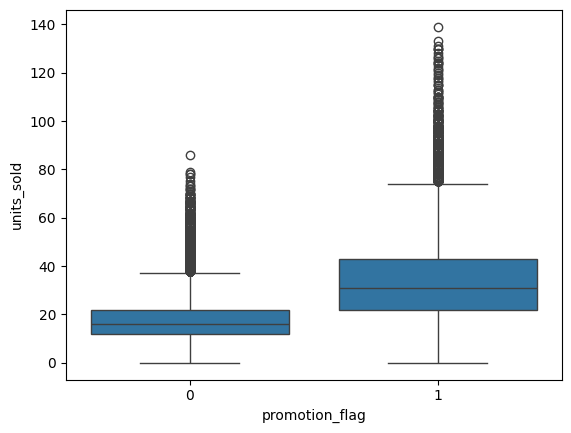

In [ ]:
sns.boxplot(x='promotion_flag', y='units_sold', data=df) # в среднем продаж с промо и без

<Axes: title={'center': 'Promo Effect by Channel'}, xlabel='channel'>

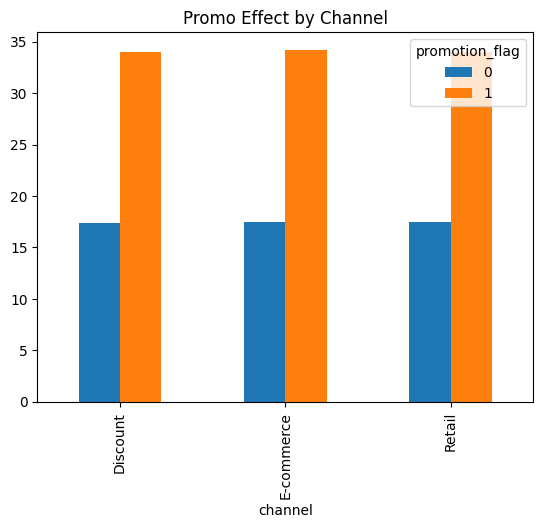

In [ ]:
promo_channel = df.groupby(['channel', 'promotion_flag'])['units_sold'].mean().unstack()
promo_channel.plot(kind="bar", title="Promo Effect by Channel")

<Axes: title={'center': 'Entries per Day'}, xlabel='date'>

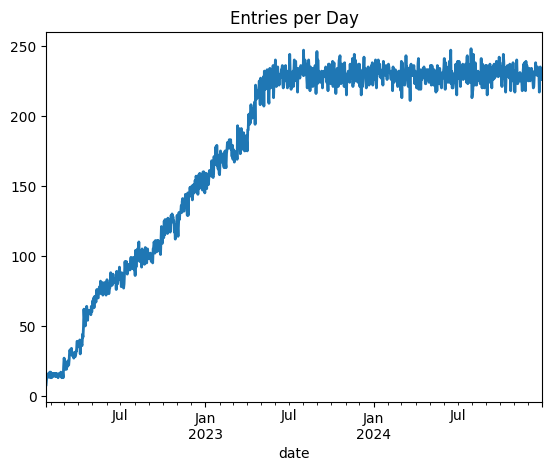

In [ ]:
df['date'].value_counts().sort_index().plot(title="Entries per Day", lw=2)

<Axes: title={'center': 'Total Units Sold over Time'}, xlabel='date'>

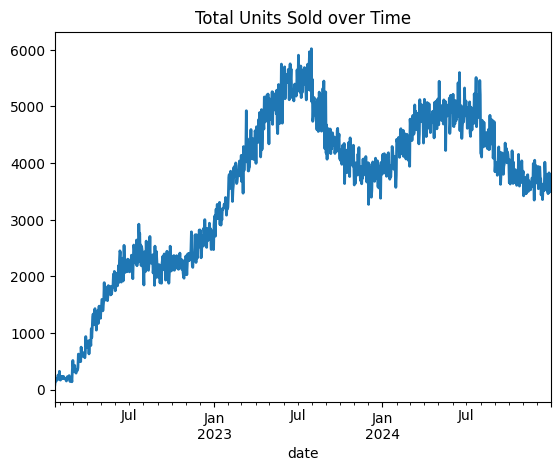

In [ ]:
df.groupby('date')['units_sold'].sum().plot(title="Total Units Sold over Time", lw=2)

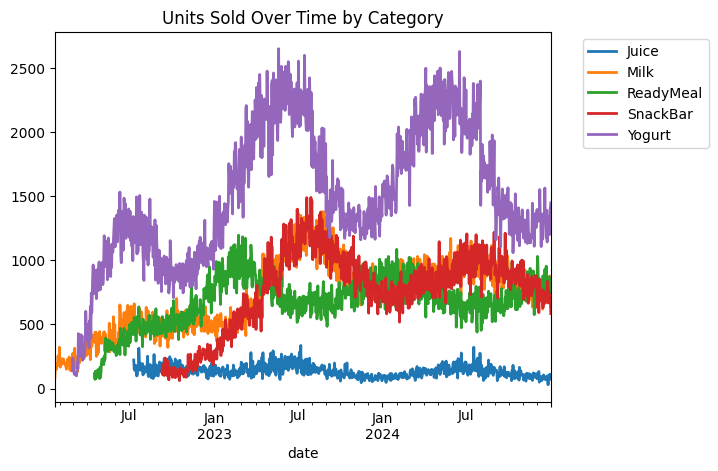

In [ ]:
df_cat_trend = df.groupby(['date', 'category'])['units_sold'].sum().unstack()
df_cat_trend.plot(title="Units Sold Over Time by Category", lw=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

In [ ]:
def plot_daily_transactions_for_sku(df, sku, date_col='date', sku_col='sku'):

    df_sku = df[df[sku_col] == sku].copy()
    df_sku[date_col] = pd.to_datetime(df_sku[date_col])

    daily_counts = df_sku.groupby(date_col).size().reset_index(name="count")
    daily_counts['7d_avg'] = daily_counts['count'].rolling(window=7).mean()

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=daily_counts[date_col],
        y=daily_counts['count'],
        name="Daily Count",
        marker_color="rgba(77,124,254,0.3)",
        hovertemplate="Date: %{x|%Y-%m-%d}<br>Transactions: %{y:,}<extra></extra>"
    ))

    fig.add_trace(go.Scatter(
        x=daily_counts[date_col],
        y=daily_counts['7d_avg'],
        mode="lines",
        name="7-day Moving Average",
        line=dict(color="#4d7cfe", width=2),
        hovertemplate="Date: %{x|%Y-%m-%d}<br>7d Avg: %{y:.1f}<extra></extra>"
    ))
    fig.update_layout(
        title=f"Daily Transaction Volume (Smoothed) — SKU: {sku}",
        xaxis_title="Date",
        yaxis_title="Transaction Count",
        plot_bgcolor="white",
        xaxis=dict(showgrid=True, gridcolor="lightgrey"),
        yaxis=dict(showgrid=True, gridcolor="lightgrey"),
        height=400,
        showlegend=True
    )

    fig.show()

In [ ]:
plot_daily_transactions_for_sku(df, sku="MI-006")

In [ ]:
def plot_event_timeline_plotly(dates, daily_values, smoothed_values,
                               event_label="Events", sku=None,
                               colors=("rgba(239,152,64,0.9)", "rgba(178,79,253,0.9)"),
                               rolling_label="Moving Average",
                               title_prefix="Daily Events"):

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=dates,
        y=daily_values,
        name=f"Daily {event_label}",
        marker_color=colors[0],
        hovertemplate="Date: %{x|%Y-%m-%d}<br>Value: %{y}<extra></extra>"
    ))

    fig.add_trace(go.Scatter(
        x=dates,
        y=smoothed_values,
        mode="lines",
        name=f"{rolling_label}",
        line=dict(color=colors[1], width=2),
        hovertemplate="Date: %{x|%Y-%m-%d}<br>{rolling_label}: %{y:.2f}<extra></extra>"
    ))
    fig.update_layout(
        title=dict(text=f"{title_prefix}{f' – SKU: {sku}' if sku else ''}", x=0.5),
        xaxis_title="Date",
        yaxis_title=f"{event_label} Count",
        plot_bgcolor="white",
        paper_bgcolor="white",
        font=dict(size=13),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        height=420
    )

    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=True, gridcolor="lightgrey")
    fig.show()

In [ ]:
df_sku = df[df['sku'] == 'MI-006'].copy()
df_sku['is_stockout'] = (df_sku['stock_available'] == 0).astype(int)

daily_counts = df_sku.groupby('date')['is_stockout'].sum()
smoothed = daily_counts.rolling(window=7).mean()


fig7=plot_event_timeline_plotly(
    dates=daily_counts.index,
    daily_values=daily_counts.values,
    smoothed_values=smoothed.values,
    event_label='Stockouts',
    sku='MI-006'
)

In [ ]:
df.select_dtypes(include=['float64', 'int64']).corr()# Построю корреляционную матрицу числовых переменных

,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
price_unit,1.000000,0.003440,0.002142,-0.002094,-0.004205,-0.001085
promotion_flag,0.003440,1.000000,-0.000683,-0.003284,-0.005634,0.503195
delivery_days,0.002142,-0.000683,1.000000,0.002940,0.002287,0.003506
stock_available,-0.002094,-0.003284,0.002940,1.000000,0.668894,0.580282
delivered_qty,-0.004205,-0.005634,0.002287,0.668894,1.000000,0.389089
units_sold,-0.001085,0.503195,0.003506,0.580282,0.389089,1.000000


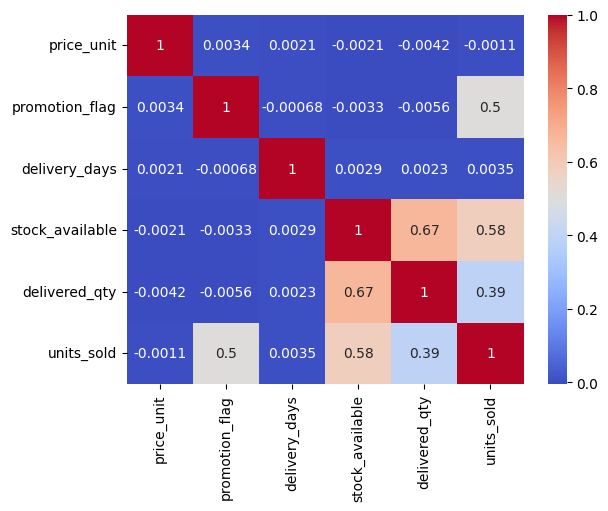

In [ ]:
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm')# Добавлю тепловую карту
plt.show()

С price_unit очень слабая отрицательная корреляция, положительная слабая корреляция с delivery_days, положительная корреляция с stock_available, promotion_flag, delivered_qty. Сильной корреляции нет. Подозрений на мультиколлинеарность нет.

## Выводы раздела

1.   Квантиль-квантильный график показывает отклонение распределения целевой переменной units_sold от нормального.
1.   Видны различия в продажах по SKU, категориям, брендам,сегментам (sku,category, brand, segment) и нет видимых по типу упаковки, региону и каналу сбыта (pack_type, region, channel).
2.   Присутствует сезонность в данных. Можно будет использовать преобразования sin/cos, чтобы помочь моделям эффективно изучать эти временные закономерности.
1.   Не в течение всего исследуемого периода времени присутствуют данные о продажах отдельных SKU. Это можно объяснить жизненным циклом продуктов - одни еще не закуплены, другие уже не закупаются.
1.   У целевой переменной units_sold присутствует очень слабая отрицательная корреляция с price_unit, положительная слабая корреляция с delivery_days, положительная корреляция с delivered_qty, положительная корреляция с promotion_flag, наибольшая положительная корреляция со stock_available.
2.   Нет подозрений на мультиколлинеарность.

| Признак         | Корреляция   | Доменная значимость| Визуальный тренд |✅ Оставить? |
|-----------------|--------------|--------------------|------------------|----      |
|`price_unit`     | ~ 0.0        |      Есть          | ?                |🔶 Возможно|
|`promotion_flag` |   0.50       |      Есть          |                  |🔶 Возможно|
|`delivery_days`  |   0.01       |      Есть          |                  |🔶 Возможно|
|`stock_available`|   0.58       |      Есть          | положит.                |✅ Да|
|`delivered_qty`  |   0.39       |      Есть          | положит.               |✅ Да|


# Подготовка данных для дальнейших этапов анализа

Создам копию базы, чтобы не потерять первоначальные данные, так как буду работать с категориальными переменными и создавать новые переменные.

In [ ]:
df1 = df.copy()

Календарь

In [ ]:
df1['day'] = df1['date'].dt.day
df1['month'] = df1['date'].dt.month
df1['year'] = df1['date'].dt.year
df1['is_start_of_month'] = df1['date'].dt.is_month_start.astype(int)
df1['is_end_of_month'] = df1['date'].dt.is_month_end.astype(int)
df1['day_of_week'] = df1['date'].dt.dayofweek
df1['is_weekend'] = df1['day_of_week'].isin([5, 6]).astype(int)

In [ ]:
print(df1.columns)
df1

Index(['date', 'sku', 'brand', 'segment', 'category', 'channel', 'region',
       'pack_type', 'price_unit', 'promotion_flag', 'delivery_days',
       'stock_available', 'delivered_qty', 'units_sold', 'day', 'month',
       'year', 'is_start_of_month', 'is_end_of_month', 'day_of_week',
       'is_weekend'],
      dtype='object')


,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,...,stock_available,delivered_qty,units_sold,day,month,year,is_start_of_month,is_end_of_month,day_of_week,is_weekend
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,...,141,128,9,21,1,2022,0,0,4,0
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,...,0,129,0,21,1,2022,0,0,4,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,...,118,161,8,21,1,2022,0,0,4,0
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,...,81,114,7,21,1,2022,0,0,4,0
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,...,148,204,12,21,1,2022,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190752,2024-12-31,SN-030,SnBrand2,SnackBar-Seg1,SnackBar,Discount,PL-North,Single,2.55,0,...,190,163,25,31,12,2024,0,1,1,0
190753,2024-12-31,SN-030,SnBrand2,SnackBar-Seg1,SnackBar,Discount,PL-South,Single,6.01,0,...,141,131,19,31,12,2024,0,1,1,0
190754,2024-12-31,SN-030,SnBrand2,SnackBar-Seg1,SnackBar,E-commerce,PL-Central,Single,3.45,0,...,0,132,0,31,12,2024,0,1,1,0
190755,2024-12-31,SN-030,SnBrand2,SnackBar-Seg1,SnackBar,E-commerce,PL-North,Multipack,1.93,1,...,211,201,40,31,12,2024,0,1,1,0


Чтобы учесть запаздывающее воздействие изменений объясняющих переменных на зависимую переменную, я введу лаги для целевой переменной.

In [ ]:
# лаг целевой переменной
for lag in [1, 2, 3, 7, 14, 28]:
    df1[f"lag_{lag}"] = df1.groupby('sku')['units_sold'].shift(lag)

# коэффициент запаздывания/моменты
df1['momentum_7_1'] = df1['lag_1'] / (df1['lag_7'] + 1e-3)
df1['momentum_14_7'] = df1['lag_7'] / (df1['lag_14'] + 1e-3)

# сглаженная статистика
df1['rolling_mean_7'] = df1.groupby('sku')['units_sold'].transform(lambda x: x.shift(1).rolling(7).mean())
df1['rolling_std_7']  = df1.groupby('sku')['units_sold'].transform(lambda x: x.shift(1).rolling(7).std())
df1['rolling_max_7']  = df1.groupby('sku')['units_sold'].transform(lambda x: x.shift(1).rolling(7).max())
df1['rolling_min_7']  = df1.groupby('sku')['units_sold'].transform(lambda x: x.shift(1).rolling(7).min())


Тренды

In [ ]:
def rolling_trend(x):
    return x.shift(1).rolling(7).apply(lambda z: np.polyfit(range(len(z)), z, 1)[0] if len(z.dropna()) == 7 else np.nan)

df1['trend_7'] = df1.groupby('sku')['units_sold'].transform(rolling_trend)

# лаги price, promo, delivery, stock
df1['price_lag_1'] = df1.groupby('sku')['price_unit'].shift(1)
df1['promo_lag_1'] = df1.groupby('sku')['promotion_flag'].shift(1)
df1['promo_effect'] = df1['promotion_flag'] * df1['lag_1']
df1['delivery_lag_7'] = df1.groupby('sku')['delivery_days'].shift(7)
df1['stock_lag_1'] = df1.groupby('sku')['stock_available'].shift(1)

In [ ]:
sku_stats = df1.groupby('sku')['units_sold'].agg(['mean', 'min', 'max', 'std']).reset_index()
sku_stats.columns = ['sku', 'sku_mean', 'sku_min', 'sku_max', 'sku_std']
df1 = df1.merge(sku_stats, on='sku', how='left')

Значения за последние 7 дней

In [ ]:
df1['category_rolling_mean_7'] = df1.groupby('category')['units_sold'].transform(lambda x: x.shift(1).rolling(7).mean())
df1['category_rolling_std_7']  = df1.groupby('category')['units_sold'].transform(lambda x: x.shift(1).rolling(7).std())

df1['price_rolling_mean_7'] = df1.groupby('sku')['price_unit'].transform(lambda x: x.shift(1).rolling(7).mean())
df1['promo_rolling_7']      = df1.groupby('sku')['promotion_flag'].transform(lambda x: x.shift(1).rolling(7).sum())

df1['day'] = df1['date'].dt.day
df1['week_of_month'] = df1['day'] // 7 + 1

In [ ]:
# индикатор того, что запасы на складе закончились
df1['stockout_flag'] = ((df1['stock_available'] == 0) & (df1['delivered_qty'] > 0)).astype(int)
df1['rolling_stockouts_7'] = df1.groupby('sku')['stockout_flag'].transform(lambda x: x.shift(1).rolling(7).sum())

# прошло времени с прошлой доставки и промоакции
def time_since_event(series):
    return series[::-1].cumsum()[::-1] * series

df1['time_since_promo'] = df1.groupby('sku')['promotion_flag'].transform(lambda x: time_since_event(x == 0))
df1['time_since_delivery'] = df1.groupby('sku')['delivery_days'].transform(lambda x: time_since_event(x == 0))

# сезонность
df1['month_sin'] = np.sin(2 * np.pi * df1['month'] / 12)
df1['month_cos'] = np.cos(2 * np.pi * df1['month'] / 12)
df1['dow_sin']   = np.sin(2 * np.pi * df1['day_of_week'] / 7)
df1['dow_cos']   = np.cos(2 * np.pi * df1['day_of_week'] / 7)

# перекрестный эффект
df1['promo_dow'] = df1['promotion_flag'] * df1['day_of_week']
df1['price_x_stock'] = df1['price_unit'] * df1['stock_available']

Обработка категориальных переменных.

In [ ]:
# преобразование категориальных переменных в числовые
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df1[['sku_cat', 'segment_cat', 'category_cat']] = enc.fit_transform(df1[['sku', 'segment', 'category']])

df1 = df1.dropna()

Выбор признаков для модели

In [ ]:
# столбцы, которые не будут использоваться в качестве признаков для модели
exclude_cols = ['date', 'sku', 'brand', 'segment', 'channel', 'region', 'pack_type', 'delivered_qty', 'units_sold', 'category']
# признаки, используемые в модели
features = [col for col in df1.columns if col not in exclude_cols and not np.issubdtype(df1[col].dtype, np.datetime64)]

# категориальные признаки, которые могут быть использованы в модели, они уже входят в features
categorical_features = [
    'sku_cat', 'segment_cat', 'category_cat',
    'day_of_week', 'month', 'is_weekend',
    'promotion_flag', 'is_start_of_month', 'is_end_of_month'
]
target = 'units_sold'

In [ ]:
features

['price_unit',
 'promotion_flag',
 'delivery_days',
 'stock_available',
 'day',
 'month',
 'year',
 'is_start_of_month',
 'is_end_of_month',
 'day_of_week',
 'is_weekend',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_7',
 'lag_14',
 'lag_28',
 'momentum_7_1',
 'momentum_14_7',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_max_7',
 'rolling_min_7',
 'trend_7',
 'price_lag_1',
 'promo_lag_1',
 'promo_effect',
 'delivery_lag_7',
 'stock_lag_1',
 'sku_mean',
 'sku_min',
 'sku_max',
 'sku_std',
 'category_rolling_mean_7',
 'category_rolling_std_7',
 'price_rolling_mean_7',
 'promo_rolling_7',
 'week_of_month',
 'stockout_flag',
 'rolling_stockouts_7',
 'time_since_promo',
 'time_since_delivery',
 'month_sin',
 'month_cos',
 'dow_sin',
 'dow_cos',
 'promo_dow',
 'price_x_stock',
 'sku_cat',
 'segment_cat',
 'category_cat']

# Работа с моделями

1.   Наивный прогноз
2.   MXGBoost/LightGB
1.   Random Forest
2.   LSTM Sequence model





## Наивный прогноз

«Наивная» модель - модель временного ряда, в которой его текущее значение равно предыдущему наблюдаемому значению этого ряда. Это самый примитивный метод прогнозирования.
Описывается выражением: y(t+1)=y(t), где y(t) — последнее наблюдаемое значение, y(t+1) — прогнозируемое значение.

In [ ]:
baseline_df1 = df1.dropna(subset=['lag_1', 'units_sold']).copy()

baseline_df1['pred_baseline'] = baseline_df1['lag_1']

mae = mean_absolute_error(baseline_df1['units_sold'], baseline_df1['pred_baseline'])
rmse = np.sqrt(mean_squared_error(baseline_df1['units_sold'], baseline_df1['pred_baseline']))
r2 = r2_score(baseline_df1['units_sold'], baseline_df1['pred_baseline'])

print("📉 Baseline Model (Naive Forecast):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

📉 Baseline Model (Naive Forecast):
MAE:  10.86
RMSE: 15.24
R²:   -0.674


Метрики

**MAPE (Mean Absolute Percentage Error)** = 1 / n ∑ᵢ₌₁ⁿ (|yᵢ - ʸᵢ / yᵢ)| × 100. Фокусируется на относительной ошибке, чувствительной к малым истинным значениям. Может быть неинформативной, если фактические значения близки к нулю.Полезна, когда важна относительная ошибка, особенно в задачах с данными, которые могут значительно варьироваться по масштабу.

**SMAPE (Symmetric Mean Absolute Percentage Error)** =  100% / n ∑ᵢ₌₁ⁿ |yᵢ - ʸᵢ| / |yᵢ| + |^_i|}. Более стабильная, чем MAPE и симметричная.Альтернатива MAPE, которая лучше работает с нулевыми значениями, так как учитывает как фактические, так и предсказанные значения в знаменателе. Полезна для задач, где важно учитывать симметричность ошибок.

**MAE (Mean Absolute Error)**  = 1 / n ∑ᵢ₌₁ⁿ |yᵢ - ^yᵢ|. Подходит, когда важно понимать среднюю абсолютную ошибку в предсказаниях.Меньше чувствительна к выбросам по сравнению с RMSE.

**RMSE (Root Mean Square Error)**  = √()n ∑ᵢ₌₁ⁿ (yᵢ - ^yᵢ)²}. Если данные имеют выбросы, то RMSE может быть более чувствительной к ним, чем MAE,так как квадрат ошибки увеличивает влияние больших отклонений. Хорошо подходит, когда большие ошибки имеют более серьезные последствия, чем маленькие.

**R² (коэффициент детерминации)** = 1 - ∑ᵢ₌₁ⁿ (yᵢ - ʸᵢ)² / ∑ᵢ₌ⁿ (yᵢ - ‾y)²}.

Что выбрать для сравнения моделей:

* Если важна интерпретируемость: **MAE** или **MAPE**.
* Если важны большие ошибки: **RMSE**.
* Если данные имеют выбросы: **MAE** или **SMAPE**.
* Если нужно оценить объясняющую способность модели: **R²**.


Для **MAE**, **RMSE**, **MAPE** и **SMAPE**: меньшие значения указывают на лучшую производительность модели.

Для **R²**: более высокие значения (ближе к 1) указывают на лучшую объясняющую способность модели.

Отрицательный  R²  говорит о том, что выбранная модель не подходит для данных. Она не может уловить закономерности и предсказывает значения хуже, чем просто использование среднего значения целевой переменной. Поэтому применю для предсказания более сложную модель.


## LightGBM Regressor

LightGBM была описана Голинь К., и соавт. в статье 2017 года под названием [«LightGBM: A Highly Efficient Gradient Boosting Decision Tree»](https://papers.nips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf).
DART описан в статье 2015 года под названием [«DART: Dropouts meet Multiple Additive Regression Trees»](https://arxiv.org/pdf/1505.01866).

In [ ]:
df1_lgbm = df1.copy()

exclude_cols = ['date', 'sku', 'brand', 'segment', 'channel', 'region', 'pack_type', 'delivered_qty', 'units_sold', 'category']
features = [col for col in df1.columns if col not in exclude_cols and not np.issubdtype(df1[col].dtype, np.datetime64)]

categorical_features = [
    'sku_cat', 'segment_cat', 'category_cat',
    'day_of_week', 'month', 'is_weekend',
    'promotion_flag', 'is_start_of_month', 'is_end_of_month'
]

target = 'units_sold'

In [ ]:
def time_split_by_date(df, feature_col, target_col, split_ratio=0.8):
    df = df.sort_values('date').reset_index(drop=True)
    unique_date = df['date'].drop_duplicates().sort_values()
    split_index = int(len(unique_date) * split_ratio)
    cutoff_date = unique_date.iloc[split_index]
    train_mask = df['date'] < cutoff_date
    test_mask = df['date'] >= cutoff_date

    X_train = df.loc[train_mask, feature_col]
    y_train = df.loc[train_mask, target_col]

    X_test = df.loc[test_mask, feature_col]
    y_test = df.loc[test_mask, target_col]

    print(f"Cutoff date for split: {cutoff_date.date()}")
    print(f"🟩 Train date: {df.loc[train_mask, 'date'].min().date()} – {df.loc[train_mask, 'date'].max().date()}")
    print(f"🟥 Test date:  {df.loc[test_mask, 'date'].min().date()} – {df.loc[test_mask, 'date'].max().date()}")

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = time_split_by_date(
    df=df1_lgbm,
    feature_col=features,
    target_col=target,
    split_ratio=0.8
)

Cutoff date for split: 2024-05-31
🟩 Train date: 2022-01-24 – 2024-05-30
🟥 Test date:  2024-05-31 – 2024-12-31


In [ ]:
def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return mean_absolute_percentage_error(y_true[mask], y_pred[mask])

In [ ]:
def train_and_evaluate_lgbm(X_train, X_test, y_train, y_test):
    model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42, verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mape = safe_mape(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape = np.mean(2 * np.abs(y_test - y_pred) /(np.abs(y_test) + np.abs(y_pred) + 1e-8))
    r2 = r2_score(y_test, y_pred)

    print("📉 LightGBM Regressor Results:")
    print(f"MAPE:   {mape:.2f}")
    print(f"SMAPE:  {smape:.2f}")
    print(f"MAE:    {mae:.2f}")
    print(f"RMSE:   {rmse:.2f}")
    print(f"R²:     {r2:.3f}")

    return model, y_pred

In [ ]:
model_lgbm, y_pred_lgbm = train_and_evaluate_lgbm(X_train, X_test, y_train, y_test)

📉 LightGBM Regressor Results:
MAPE:   0.22
SMAPE:  0.23
MAE:    3.54
RMSE:   5.00
R²:     0.774


Эта модель явно лучше, чем модель наивного прогноза.

Прогоню ту же самую модель только уже в разбивке по категориям и товарам. Обучение тоже будет производиться отдельно для каждой категории и товара.

In [ ]:
def train_and_evaluate_lgbm_sku(df, feature_col, target_col):
    results = []
    # Группиру данные по SKU и категории
    grouped = df.groupby(['sku', 'category'])

    for (sku, category), group in grouped:
        X = group[feature_col]
        y = group[target_col]
        # Разделяю на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = time_split_by_date(
            df=group,
            feature_col=features,
            target_col=target_col,
            split_ratio=0.8
        )

        # Обучаю модель
        model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42, verbose=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Метрики
        mae = mean_absolute_error(y_test, y_pred)
        mape = safe_mape(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        smape = np.mean(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred) + 1e-8))
        r2 = r2_score(y_test, y_pred)

        # Сохраняю результаты
        results.append({
            'sku': sku,
            'category': category,
            'MAPE': mape,
            'SMAPE': smape,
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        })

    # Создаю DataFrame с результатами
    results_df = pd.DataFrame(results)
    return results_df

# Вызов функции для оценки модели
results_df = train_and_evaluate_lgbm_sku(df1_lgbm, features, target)

Cutoff date for split: 2024-07-04
🟩 Train date: 2022-07-14 – 2024-07-03
🟥 Test date:  2024-07-04 – 2024-12-31
Cutoff date for split: 2024-08-22
🟩 Train date: 2023-03-15 – 2024-08-21
🟥 Test date:  2024-08-22 – 2024-12-31
Cutoff date for split: 2024-05-31
🟩 Train date: 2022-01-24 – 2024-05-30
🟥 Test date:  2024-05-31 – 2024-12-31
Cutoff date for split: 2024-08-28
🟩 Train date: 2023-04-15 – 2024-08-27
🟥 Test date:  2024-08-28 – 2024-12-31
Cutoff date for split: 2024-08-27
🟩 Train date: 2023-04-07 – 2024-08-26
🟥 Test date:  2024-08-27 – 2024-12-31
Cutoff date for split: 2024-07-21
🟩 Train date: 2022-10-08 – 2024-07-20
🟥 Test date:  2024-07-21 – 2024-12-31
Cutoff date for split: 2024-06-28
🟩 Train date: 2022-06-13 – 2024-06-27
🟥 Test date:  2024-06-28 – 2024-12-31
Cutoff date for split: 2024-05-31
🟩 Train date: 2022-01-26 – 2024-05-30
🟥 Test date:  2024-05-31 – 2024-12-31
Cutoff date for split: 2024-06-17
🟩 Train date: 2022-04-20 – 2024-06-16
🟥 Test date:  2024-06-17 – 2024-12-31
Cutoff dat

Сотрю лучшие 10 результатов по MAPE

In [ ]:
top_10_results = results_df.sort_values(by='MAPE', ascending=False).head(10)
print("\nBest SKUs by MAPE:")
print(top_10_results)


Best SKUs by MAPE:
       sku  category      MAPE     SMAPE       MAE      RMSE        R²
4   MI-011      Milk  0.347859  0.302997  3.813530  4.905019  0.591019
3   MI-008      Milk  0.330073  0.297636  3.602750  4.868436  0.535324
19  YO-001    Yogurt  0.289748  0.273429  3.611241  5.023878  0.690967
14  SN-013  SnackBar  0.287888  0.278253  3.710255  4.843073  0.677539
18  SN-030  SnackBar  0.281977  0.269605  4.414231  5.861690  0.688538
26  YO-018    Yogurt  0.280943  0.276692  3.796827  5.151147  0.662050
0   JU-021     Juice  0.280322  0.264638  3.682212  5.211251  0.723348
28  YO-024    Yogurt  0.271591  0.249713  3.910106  5.229024  0.590416
23  YO-012    Yogurt  0.253322  0.258491  3.985751  5.504886  0.769309
24  YO-014    Yogurt  0.249964  0.244911  3.189388  4.508744  0.722689


Смотрю худшие MAPE

In [ ]:
bottom_10_results = results_df.sort_values(by='MAPE', ascending= True).head(10)
print("\n Worst SKUs by MAPE:")
print(bottom_10_results)


 Worst SKUs by MAPE:
       sku   category      MAPE     SMAPE       MAE      RMSE        R²
12  RE-025  ReadyMeal  0.187447  0.217001  3.319110  4.604614  0.780391
11  RE-017  ReadyMeal  0.191840  0.215045  3.423707  4.858460  0.777974
7   MI-026       Milk  0.196949  0.213776  3.236360  4.553393  0.758752
2   MI-006       Milk  0.207200  0.223027  2.829310  4.131446  0.732592
15  SN-019   SnackBar  0.208620  0.217961  3.676397  5.246966  0.736267
9   RE-007  ReadyMeal  0.210147  0.226095  3.280555  4.601902  0.783042
6   MI-023       Milk  0.210527  0.226933  3.420981  4.852152  0.754644
13  SN-010   SnackBar  0.217488  0.238873  3.843791  5.268828  0.761571
17  SN-028   SnackBar  0.221456  0.218376  3.966252  5.629913  0.722604
10  RE-015  ReadyMeal  0.222145  0.231464  3.468521  4.966420  0.762406


## LightGBM Extended

Дообогащу модель дополнительными признаками и посмотрю, будет ли улучшение метрик.

In [ ]:
df1_lgbm = df1.copy()
df1_lgbm = df1_lgbm.sort_values(['channel', 'region', 'day_of_week']).reset_index(drop=True)

lag_days = [1, 7, 14]
rolling_windows = [7, 14]

for lag in lag_days:
    df1_lgbm[f'units_sold_lag_{lag}'] = (
        df1_lgbm.groupby(['channel', 'region'])['units_sold'].shift(lag)
    )

for window in rolling_windows:
    df1_lgbm[f'rolling_mean_{window}'] = (
        df1_lgbm.groupby(['channel', 'region'])['units_sold']
        .shift(1).rolling(window=window).mean().reset_index(level=0, drop=True)
    )
    df1_lgbm[f'rolling_std_{window}'] = (
        df1_lgbm.groupby(['channel', 'region'])['units_sold']
        .shift(1).rolling(window=window).std().reset_index(level=0, drop=True)
    )

In [ ]:
df1_lgbm = df1_lgbm.dropna().reset_index(drop=True)

In [ ]:
df1_lgbm[[col for col in df1_lgbm.columns if 'lag' in col or 'rolling' in col]].head()

,promotion_flag,lag_1,lag_2,lag_3,lag_7,lag_14,lag_28,rolling_mean_7,rolling_std_7,rolling_max_7,...,category_rolling_std_7,price_rolling_mean_7,promo_rolling_7,stockout_flag,rolling_stockouts_7,units_sold_lag_1,units_sold_lag_7,units_sold_lag_14,rolling_mean_14,rolling_std_14
0,0,62.0,22.0,13.0,27.0,28.0,26.0,24.142857,16.108265,62.0,...,16.607514,6.730000,1.0,0,0.0,22.0,4.0,17.0,17.714286,13.111525
1,0,18.0,23.0,12.0,11.0,20.0,29.0,25.714286,14.244464,36.0,...,3.728909,4.468571,1.0,0,0.0,15.0,38.0,16.0,17.571429,13.130788
2,0,29.0,9.0,14.0,7.0,28.0,18.0,21.428571,14.443651,33.0,...,7.521398,5.798571,1.0,0,0.0,8.0,50.0,11.0,17.000000,13.376213
3,0,27.0,15.0,7.0,21.0,13.0,28.0,18.571429,8.676734,27.0,...,8.629959,5.677143,0.0,0,0.0,30.0,8.0,5.0,18.357143,13.681021
4,0,38.0,20.0,9.0,26.0,18.0,32.0,20.142857,7.335498,38.0,...,12.902565,4.110000,0.0,0,0.0,19.0,27.0,10.0,19.357143,13.130160


In [ ]:
for col in ['channel', 'region']:
    df1_lgbm[col] = df1_lgbm[col].astype('category')

    exclude_cols = ['date', 'sku', 'brand', 'segment', 'channel', 'region', 'pack_type', 'delivered_qty', 'units_sold', 'category']
    features = [col for col in df1_lgbm.columns if col not in exclude_cols and not np.issubdtype(df1_lgbm[col].dtype, np.datetime64)]

    categorical_features = [
    'sku_cat', 'segment_cat', 'category_cat',
    'day_of_week', 'month', 'is_weekend',
    'promotion_flag', 'is_start_of_month', 'is_end_of_month'
]

target = 'units_sold'

X_train_ex, X_test_ex, y_train_ex, y_test_ex = time_split_by_date(
    df=df1_lgbm,
    feature_col=features,
    target_col=target,
    split_ratio=0.8
)

Cutoff date for split: 2024-06-01
🟩 Train date: 2022-01-25 – 2024-05-31
🟥 Test date:  2024-06-01 – 2024-12-31


In [ ]:
model_lgbm_ex, y_pred_lgbm_ex = train_and_evaluate_lgbm(X_train_ex, X_test_ex, y_train_ex, y_test_ex)

📉 LightGBM Regressor Results:
MAPE:   0.22
SMAPE:  0.23
MAE:    3.57
RMSE:   5.03
R²:     0.771


Улучшения метрик не произошло - MAE изменилось с 3.54 до 3.57. Для MAE, чем меньше значение, тем лучше производительность модели. Попробую улучшить модель, перейдя к логарифму целевой переменной.

## LightGBM Extended Log-Transformed Target

In [ ]:
def train_lgbm_log_target(X_train, X_test, y_train, y_test):
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train_log)

    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_test, y_pred)
    mape = safe_mape(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    smape = np.mean(2 * np.abs(y_test - y_pred) /(np.abs(y_test) + np.abs(y_pred) + 1e-8))
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("📉 LightGBM with Log1p Target:")
    print(f"MAPE: ", round(mape,2))
    print(f"SMAPE ", round(smape,2))
    print("MAE: ", round(mae, 2))
    print("RMSE:", round(rmse, 2))
    print("R²:  ", round(r2, 3))

    return model

model_lgbm_log = train_lgbm_log_target(X_train, X_test, y_train, y_test)

📉 LightGBM with Log1p Target:
MAPE:  0.21
SMAPE  0.23
MAE:  3.38
RMSE: 4.85
R²:   0.788


In [ ]:
def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true.values, label="Actual", marker='o', linewidth=2)
    plt.plot(y_pred, label="Predicted", marker='o', linestyle='--', alpha=0.8)

    plt.title(title, fontsize=14)
    plt.xlabel("Observation", fontsize=12)
    plt.ylabel("Units Sold", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

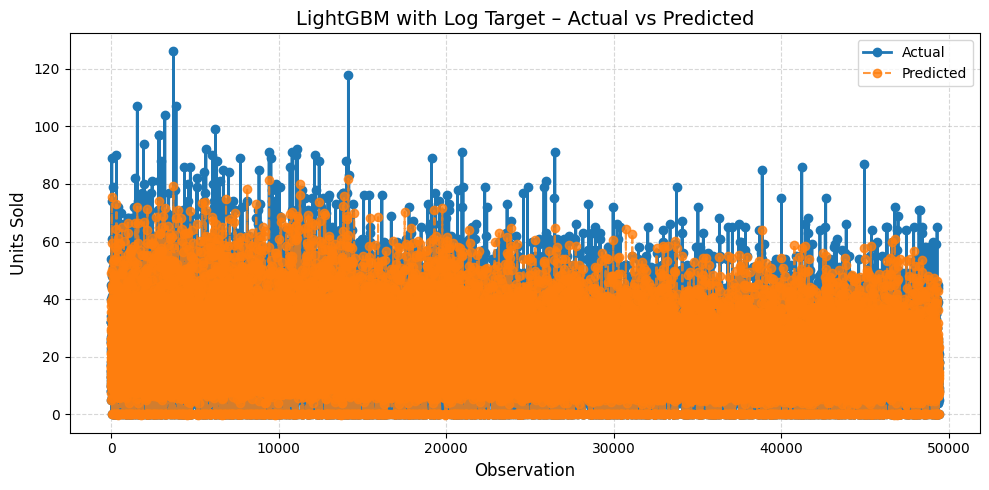

In [ ]:
y_pred_lgbm_log = np.expm1(model_lgbm_log.predict(X_test))

plot_actual_vs_predicted(y_test.reset_index(drop=True), y_pred_lgbm_log, title="LightGBM with Log Target – Actual vs Predicted")

Из графика видно, что модель улавливает основные тренды. По метрике MAE модель с логарифмом имеет лучшую производительность, чем предыдущие.

## LightGBM Add Proxy Feature

Чтобы улучшить предсказательную силу модели я добавлю новую переменную, которая бы содержала информацию о спросе на товар в регионе.

In [ ]:
df2 = df1.copy()
df2['avg_by_channel_region'] = (
    df2.groupby(['channel', 'region', 'date'])['units_sold'].transform('mean')
)
df2 = df2[df2['sku'] == 'MI-006'].copy()
df2['date'] = pd.to_datetime(df2['date'])

df2[['sku', 'channel', 'region', 'date', 'units_sold', 'avg_by_channel_region']].head()

,sku,channel,region,date,units_sold,avg_by_channel_region
39,MI-006,Discount,PL-South,2022-01-24,11,11.0
40,MI-006,E-commerce,PL-Central,2022-01-24,9,9.0
41,MI-006,E-commerce,PL-North,2022-01-24,0,0.0
47,MI-006,Retail,PL-Central,2022-01-25,22,22.0
48,MI-006,Retail,PL-North,2022-01-25,11,11.0


In [ ]:
df2_lgbm = df2.sort_values('date').reset_index(drop=True)

for col in ['channel', 'region']:
    df2_lgbm[col] = df2_lgbm[col].astype('category')
print(df2_lgbm.columns)

exclude_cols = ['date', 'sku', 'brand', 'segment', 'channel', 'region', 'pack_type', 'delivered_qty', 'units_sold', 'category']
features = [col for col in df2_lgbm.columns if col not in exclude_cols and not np.issubdtype(df2_lgbm[col].dtype, np.datetime64)]

categorical_features = [
    'sku_cat', 'segment_cat', 'category_cat',
    'day_of_week', 'month', 'is_weekend',
    'promotion_flag', 'is_start_of_month', 'is_end_of_month'
]

target = 'units_sold'

missing_features = [col for col in features if col not in df2_lgbm.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    X_train, X_test, y_train, y_test = time_split_by_date(
      df=df2_lgbm,
      feature_col=features,
      target_col=target,
      split_ratio=0.8
)

Index(['date', 'sku', 'brand', 'segment', 'category', 'channel', 'region',
       'pack_type', 'price_unit', 'promotion_flag', 'delivery_days',
       'stock_available', 'delivered_qty', 'units_sold', 'day', 'month',
       'year', 'is_start_of_month', 'is_end_of_month', 'day_of_week',
       'is_weekend', 'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_28',
       'momentum_7_1', 'momentum_14_7', 'rolling_mean_7', 'rolling_std_7',
       'rolling_max_7', 'rolling_min_7', 'trend_7', 'price_lag_1',
       'promo_lag_1', 'promo_effect', 'delivery_lag_7', 'stock_lag_1',
       'sku_mean', 'sku_min', 'sku_max', 'sku_std', 'category_rolling_mean_7',
       'category_rolling_std_7', 'price_rolling_mean_7', 'promo_rolling_7',
       'week_of_month', 'stockout_flag', 'rolling_stockouts_7',
       'time_since_promo', 'time_since_delivery', 'month_sin', 'month_cos',
       'dow_sin', 'dow_cos', 'promo_dow', 'price_x_stock', 'sku_cat',
       'segment_cat', 'category_cat', 'avg_by_channel_regi

In [ ]:
model_lgbm_add, y_pred_lgbm_add = train_and_evaluate_lgbm(X_train, X_test, y_train, y_test)

📉 LightGBM Regressor Results:
MAPE:   0.20
SMAPE:  0.22
MAE:    2.78
RMSE:   3.99
R²:     0.751


Среди моделей LightGBM наилучшую производительность показала LightGBM с дополнительной переменной, отвечающей за спрос по регионам

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
df3=df2_lgbm.copy()

exclude_cols = ['date', 'sku', 'brand', 'segment', 'channel', 'region', 'pack_type', 'delivered_qty', 'units_sold', 'category']
features = [col for col in df3.columns if col not in exclude_cols and not np.issubdtype(df3[col].dtype, np.datetime64)]

categorical_features = [
    'sku_cat', 'segment_cat', 'category_cat',
    'day_of_week', 'month', 'is_weekend',
    'promotion_flag', 'is_start_of_month', 'is_end_of_month'
]

target = 'units_sold'

df3['channel'] = df3['channel'].astype('category')
df3['region'] = df3['region'].astype('category')
df3['channel_cat'] = df3['channel'].cat.codes
df3['region_cat'] = df3['region'].cat.codes

features_encoded = [col if col not in ['channel', 'region'] else f"{col}_cat" for col in features]
df_sorted = df3.sort_values('date').reset_index(drop=True)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = time_split_by_date(
    df=df_sorted,
    feature_col=features_encoded,
    target_col=target,
    split_ratio=0.8
)
# Обучаю модель
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_test_rf)

# Метрики
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
mape_rf = safe_mape(y_test_rf, y_pred_rf)
smape_rf = np.mean(2 * np.abs(y_test_rf - y_pred_rf) /(np.abs(y_test_rf) + np.abs(y_pred_rf) + 1e-8))
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
r2_rf = r2_score(y_test_rf, y_pred_rf)

Cutoff date for split: 2024-05-31
🟩 Train date: 2022-01-24 – 2024-05-30
🟥 Test date:  2024-05-31 – 2024-12-31


In [ ]:
y_train_rf_log = np.log1p(y_train_rf)
y_test_rf_log = np.log1p(y_test_rf)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf, y_train_rf_log)
y_pred_rf_log = rf_model.predict(X_test_rf)
y_pred_rf = np.expm1(y_pred_rf_log)

print("📉 Random Forest with Log1p Target:")
print(f"MAPE: ", round(mape_rf,2))
print(f"SMAPE ", round(smape_rf,2))
print("MAE:  ", round(mae_rf, 2))
print("RMSE: ", round(rmse_rf, 2))
print("R²:   ", round(r2_rf, 3))

📉 Random Forest with Log1p Target:
MAPE:  0.5
SMAPE  0.39
MAE:   5.71
RMSE:  6.86
R²:    0.263


## RF GridSearchCV

Применение алгоритмов глубокого обучения для гиперпараметрического поиска
Применю метод поиска лучших гиперпараметров модели. Есть разные способы поиска лучших гиперпараметров, например: решетчатый (Grid Search) подход, случайный поиск (Random Search), оптимизация с использованием байесовских методов (Bayesian Optimization), применение алгоритмов глубокого обучения (например, генетический алгоритм или оптимизация через градиент). Я произвольно выбрала решетчатый метод, без какого либо сравнения вариантов.

In [ ]:
y_train_rf_log = np.log1p(y_train_rf)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 0.8]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_rf, y_train_rf_log)
grid_search.best_params_, grid_search.best_score_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


({'max_depth': None,
  'max_features': 0.8,
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 100},
 np.float64(-0.24760427924533066))

In [ ]:
best_rf_log = grid_search.best_estimator_
y_pred_best_rf_log = best_rf_log.predict(X_test_rf)
y_pred_best_rf = np.expm1(y_pred_best_rf_log)

mae_rf = mean_absolute_error(y_test_rf, y_pred_best_rf)
mape_rf = safe_mape(y_test_rf, y_pred_rf)
smape_rf = np.mean(2 * np.abs(y_test_rf - y_pred_rf) /(np.abs(y_test_rf) + np.abs(y_pred_rf) + 1e-8))
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_best_rf))
r2_rf = r2_score(y_test_rf, y_pred_best_rf)

print("📉 Best Random Forest (from GridSearch) — Evaluation on Original Scale:")
print(f"MAPE: ", round(mape_rf,2))
print(f"SMAPE ", round(smape_rf,2))
print("MAE:  ", round(mae_rf, 2))
print("RMSE: ", round(rmse_rf, 2))
print("R²:   ", round(r2_rf, 3))

📉 Best Random Forest (from GridSearch) — Evaluation on Original Scale:
MAPE:  0.44
SMAPE  0.33
MAE:   4.99
RMSE:  6.22
R²:    0.393


## Random Forest итоговый вариант

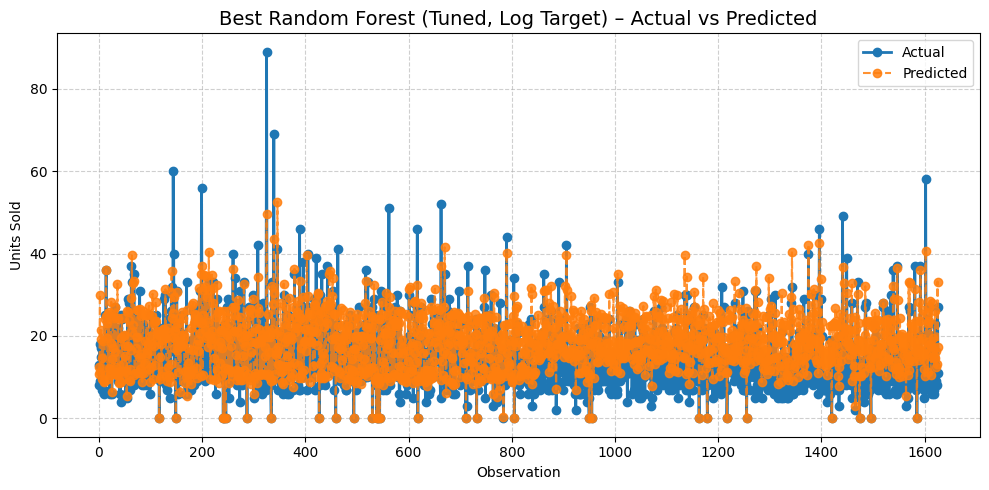

In [ ]:
y_pred_best_rf_log = best_rf_log.predict(X_test_rf)
y_pred_best_rf = np.expm1(y_pred_best_rf_log)

y_true = y_test_rf.reset_index(drop=True)
y_pred = pd.Series(y_pred_best_rf)

plt.figure(figsize=(10, 5))
plt.plot(y_true, label="Actual", marker='o', linewidth=2)
plt.plot(y_pred, label="Predicted", marker='o', linestyle='--', alpha=0.85)

plt.title("Best Random Forest (Tuned, Log Target) – Actual vs Predicted", fontsize=14)
plt.xlabel("Observation")
plt.ylabel("Units Sold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

По приведенному выше графику видно, что модель отражает тенденцию продаж.

## LSTM Sequence model

LSTM (Long Short-Term Memory) относится к классу искусственных нейронных сетей (ANN). Это специфический тип рекуррентной нейронной сети (RNN), который был разработан для решения проблемы затухающего градиента, что делает его особенно эффективным для работы с последовательными данными, такими как временные ряды.

При первом подходе к моделированию столкнулась с тем, что прогнозы принимали отрицательные значения. Чтобы этого избежать, так как целевая переменная 'units_sold' - продажи единиц товара не может принимать отрицательные значения, то можно внести следующие изменения в модель - обрезать отрицательные предсказания или использовать более элегантный способ - функцию активации, ограничивающую выходные значения. Я выбираю в качестве функции активации ReLU (Rectified Linear Unit) в последнем слое модели.

In [ ]:
df1_lstm = df1.copy()
# Определяю исключаемые колонки и целевую переменную
exclude_cols = ['date', 'sku', 'brand', 'segment', 'channel', 'region', 'pack_type', 'delivered_qty', 'units_sold', 'category']
features = [col for col in df1_lstm.columns if col not in exclude_cols and not np.issubdtype(df1_lstm[col].dtype, np.datetime64)]

categorical_features = [
    'sku_cat', 'segment_cat', 'category_cat',
    'day_of_week', 'month', 'is_weekend',
    'promotion_flag', 'is_start_of_month', 'is_end_of_month'
]

target = 'units_sold'

In [ ]:
def time_split_by_date(df, feature_col, target_col, split_ratio=0.8):
    df = df.sort_values('date').reset_index(drop=True)

    unique_date = df['date'].drop_duplicates().sort_values()
    split_index = int(len(unique_date) * split_ratio)
    cutoff_date = unique_date.iloc[split_index]

    train_mask = df['date'] < cutoff_date
    test_mask = df['date'] >= cutoff_date

    X_train = df.loc[train_mask, features]
    y_train = df.loc[train_mask, target_col]

    X_test = df.loc[test_mask, features]
    y_test = df.loc[test_mask, target_col]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = time_split_by_date(
    df=df1_lstm,
    feature_col=features,
    target_col=target,
    split_ratio=0.8
)

In [ ]:
# Нормализация данных
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
# Функция для преобразования данных в формат [samples, time_steps, features]
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


time_steps = 1  #Создаю временные ряды, временной шаг=1
X_train_lstm, y_train_lstm = create_dataset(X_train_scaled, y_train_scaled, time_steps)
X_test_lstm, y_test_lstm = create_dataset(X_test_scaled, y_test_scaled, time_steps)
# Изменяю форму данных для LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2]))

In [ ]:
print(f"✅ Sequences prepared: {X_train_lstm.shape[0]} train | {X_test_lstm.shape[0]} test")

✅ Sequences prepared: 140533 train | 49379 test


In [ ]:
# Определяю модель LSTM
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(tf.keras.layers.Dense(1, activation='relu'))# для выхода
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Обучаю модель с ранней остановкой
model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
    )           # пока поставила 0, но лучше 1 или 2, тогда будет видно инфу по обучению

Epoch 1/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0073
Epoch 2/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0069
Epoch 3/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0068
Epoch 4/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0068
Epoch 5/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0068
Epoch 6/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0067
Epoch 7/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0068
Epoch 8/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0068
Epoch 9/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0068
Epoch 10/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0068
Epoch 11/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0068
Epoch 12/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0067
Epoch 13/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0067
Epoch 14/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0067
E

In [ ]:
# Предсказания
y_pred_scaled = model.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)

1544/1544 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
# Оценка модели
predictions = model.predict(X_test_lstm)
predictions = scaler_y.inverse_transform(predictions)  # Обратное преобразование

1544/1544 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
# Метрики
mae = mean_absolute_error(y_test[time_steps:], y_pred_lstm)
rmse = np.sqrt(mean_squared_error(y_test[time_steps:], y_pred_lstm))
r2 = r2_score(y_test[time_steps:], y_pred_lstm)

print("📉 LSTM Results:")
print(f"MAE:    {mae:.2f}")
print(f"RMSE:   {rmse:.2f}")
print(f"R²:     {r2:.3f}")

📉 LSTM Results:
MAE:    7.25
RMSE:   10.24
R²:     0.053


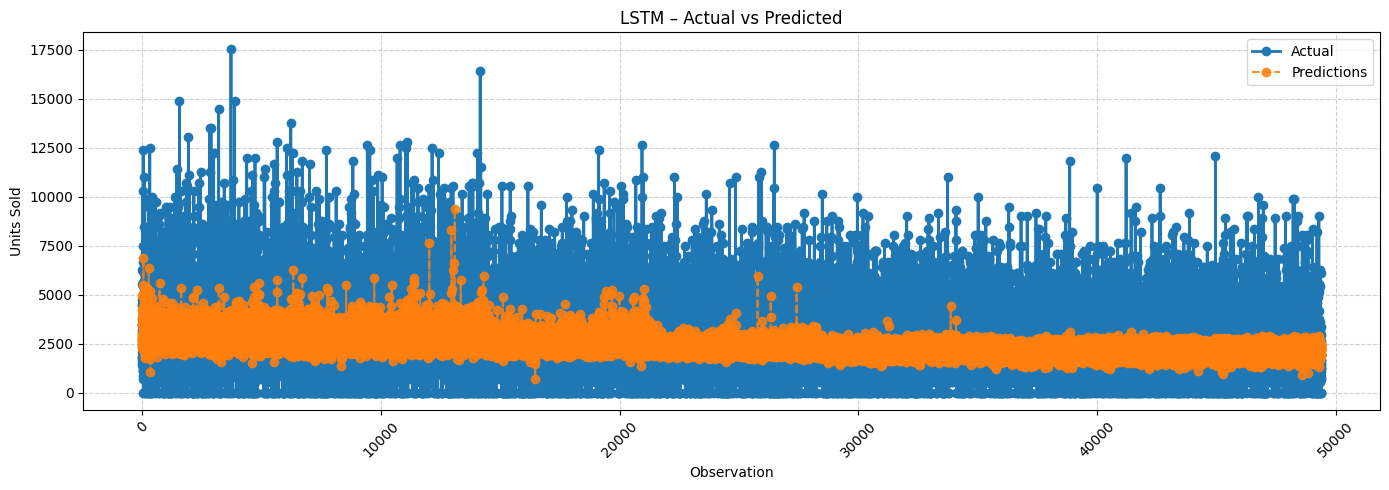

In [ ]:
# Визуализация результатов
plt.figure(figsize=(14, 5))
# Инвертирую масштабирование для значений
true_values = scaler_y.inverse_transform(y_test.values[time_steps:].reshape(-1, 1))
predictions = scaler_y.inverse_transform(y_pred_lstm.reshape(-1, 1))
# Получаю даты для отображения, можно не использовать, так как другие графики без дат, а с наблюдениями
dates = df1_lstm['date'].values[-len(y_test[time_steps:]):]

plt.plot(true_values, label="Actual",  marker='o', linewidth=2)
plt.plot(predictions, label="Predictions", marker='o',linestyle='--', alpha=0.85 )
plt.title("LSTM – Actual vs Predicted")
plt.xlabel("Observation")
plt.ylabel("Units Sold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Модель не достаточно хорошо предсказывает значение целевой переменной - хуже, чем Random Forest и вариации LightGBM модели.

## Выводы раздела
| Model Variant                  | MAPE | SMAPE | MAE   | RMSE  |R²      |
|--------------------------------|------|-------|-------|-------|--------|
| Baseline (Lag-1)               |      |       | 10.86 | 15.24 | −0.674 |
| LightGBM (basic)              | 0.22 | 0.23 | 3.54 | 5.00 | 0.774 |
| LightGBM (extended)     | 0.22 | 0.23 | 3.57 | 5.03 | 0.771 |
| LightGBM (log target)           | 0.21 | 0.23 | 3.38 | 4.85 | 0.788 |
| + `avg_by_channel_region`         | 0.20 | 0.22 | 2.78 | 3.99 | 0.751 |
| Random Forest    | 0.50 | 0.39 | 5.71 | 6.86 | 0.263 |
| Random Forest (tuned) | 0.44 | 0.33 | 4.99 | 6.22 | 0.393 |
| LSTM Sequence |  |  | 7.34 | 10.32 | 0.038 |

Чем меньше MAE, тем лучше производительность модели, по R² - объясняющую способность модели. По основным метрикам наилучший результат выдает LightGBM модель с дополнительной переменной `avg_by_channel_region`, которая содержит информацию о спросе на товар в регионе.

# Дальнейшее развитие исследования

* Изменить глубину прогноза до еженедельных и ежеквартальных продаж.
* Применить для улучшения точности прогнозирования гибридные модели, которые основаны на взвешенных усредненных предсказаниях разных обученных моделей.
* Использовать возможности библиотеки Prophet для прогнозирования (Sean J. Taylor, Benjamin Letham "Forecasting at scale" ). !pip install --upgrade fbprophet. https://dzen.ru/a/X9zn_zcTo3uGvQEC?ysclid=me7b50nyf0931026257 https://otexts.com/fpp2/ https://habr.com/ru/companies/ods/articles/323730/ https://pbpython.com/prophet-overview.html https://facebook.github.io/prophet/ https://github.com/facebook/prophet
* Выполнить прескриптивный анализ, используя машинное обучение с подкреплением (RL), для автоматизации процесса принятия решений на основе созданных прогнозов.

